# Part 1

In [577]:
#工具包
from jqdata import *
import datetime
import pandas as pd
import numpy as np
from six import StringIO
import warnings
import time
import pickle
from jqfactor import winsorize_med
from jqfactor import neutralize
from jqfactor import standardlize
import statsmodels.api as sm
warnings.filterwarnings("ignore")
matplotlib.rcParams['axes.unicode_minus']=False

In [578]:
#获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid,start_date, end_date):
    #设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    #记录每个周期中最后一个交易日
    stock_data['date']=stock_data.index
    #进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data=stock_data.resample(peroid,how='last')
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date=start_date-datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list=date_only_series.values.tolist()
    date_list.insert(0,start_date)
    TradeDate = []
    for i in date_list:
        temp = list(get_trade_days(end_date=i, count=1))[0]
        TradeDate.append(str(temp))
    return TradeDate
#np.array(get_period_date('M', '2010-01-01', '2020-01-01'))

In [579]:
#获取数据
start = time.clock()
begin_date = '2015-02-01'
end_date = '2020-01-01'
TradeDate = get_period_date('M',begin_date, end_date)
factorData = {}
for date in TradeDate: # 000002.XSHG 上证A股 399107.XSHE 深证A股
    stockList = get_index_stocks('000002.XSHG',date) + get_index_stocks('399107.XSHE',date)
    df_volume = get_price(stockList, count = 1, end_date = date, frequency='1d', fields=['volume'])['volume']
    df_fund = get_fundamentals(query(valuation.code, valuation.turnover_ratio, valuation.pe_ratio,
                                    valuation.capitalization,valuation.market_cap
                                    ).filter(valuation.code.in_(stockList),valuation.pe_ratio>0), date = date)       
    #选取了turnover_ratio,pe_ratio，capitalization
    df_fund = df_fund.set_index(['code'])
    df_fund['volume'] = df_volume.T
    factorData[date] = df_fund
elapsed = (time.clock() - start)
print("Time used:",elapsed)

Time used: 66.32375400000001


In [580]:
import matplotlib.pyplot as plt

industry_name=get_industries(name='sw_l1', date=None)
industry_name.drop(['801060','801070','801090','801100','801190','801220'])#这些行业于2014年取消
industry_codes=list(industry_name.index)
Fields = ['turnover_ratio', 'pe_ratio', 'capitalization']#选取了三个指标

def getExplore(index):
    explore = pd.DataFrame(index = TradeDate)
    for i in Fields: # Fields: different financial factors
        tempExplore = []
        for date in TradeDate:
            stockList = get_industry_stocks(index, date)
            temp = factorData[date][[i]]
            temp = temp.sort_values([i],ascending = False)
            temp['rank'] = range(len(temp)+1, 1, -1)
            # 获取行业股票在全市场股票中的平均排位
            tempExplore.append((temp.loc[stockList,'rank'].mean() - len(temp) / 2) / len(temp))
        explore[i] = tempExplore
    return explore

#选取每个因子暴露的首尾行业
aa=pd.DataFrame(columns=industry_codes)
aa['fields']=Fields
aa.set_index('fields',inplace=True)

for i in range(len(industry_codes)):
    explore_=getExplore(industry_codes[i])
    bb=[]
    for j in Fields:
        bb.append(explore_[j].mean())
    aa[industry_codes[i]]=bb
aa

,801740,801020,801110,801160,801060,801770,801010,801120,801750,801050,801890,801170,801090,801710,801780,801040,801130,801880,801180,801230,801220,801760,801200,801140,801720,801080,801790,801030,801100,801190,801210,801730,801070,801150
fields,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
turnover_ratio,0.028801,-0.071288,-0.038432,-0.096732,NaN,0.115443,-0.008663,-0.025884,0.124813,0.042062,0.043074,-0.114967,NaN,0.018708,-0.202216,-0.097763,-0.026394,0.006672,-0.130466,-0.030444,NaN,0.010216,-0.089108,0.031538,0.017392,0.109325,-0.073259,0.032221,NaN,NaN,-0.082921,0.002088,NaN,-0.038785
pe_ratio,0.253779,-0.073168,-0.077888,-0.110919,NaN,0.131058,0.047674,0.008832,0.166383,0.086620,0.108364,-0.144293,NaN,-0.031977,-0.470894,-0.199920,-0.031804,-0.069729,-0.169532,0.108528,NaN,-0.003306,-0.085884,0.022736,-0.105595,0.087370,-0.162723,-0.007431,NaN,NaN,0.013018,0.042212,NaN,0.003402
capitalization,0.030654,0.221692,0.017788,0.122674,NaN,-0.069698,0.002755,0.008223,-0.100839,0.095585,-0.130439,0.180555,NaN,-0.024313,0.464470,0.266693,-0.059157,-0.045410,0.208921,0.014577,NaN,0.054829,0.043072,-0.073077,0.029972,-0.065656,0.360891,-0.059471,NaN,NaN,-0.087831,-0.034639,NaN,-0.056122


In [581]:
#每个指标第一和最后一名的行业
ee=[]
for i in Fields:
    cc=list(aa.T.dropna().sort_values(by=i,ascending = False).head(1).index.values)
    dd=list(aa.T.dropna().sort_values(by=i,ascending = False).tail(1).index.values)
    ee.append(cc[0])
    ee.append(dd[0])
#去除重复项
ee=list(set(ee))
ee

['801750', '801890', '801780', '801740']

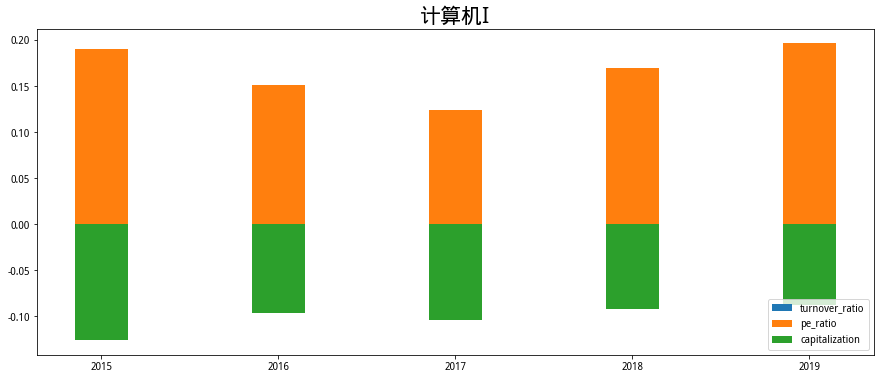

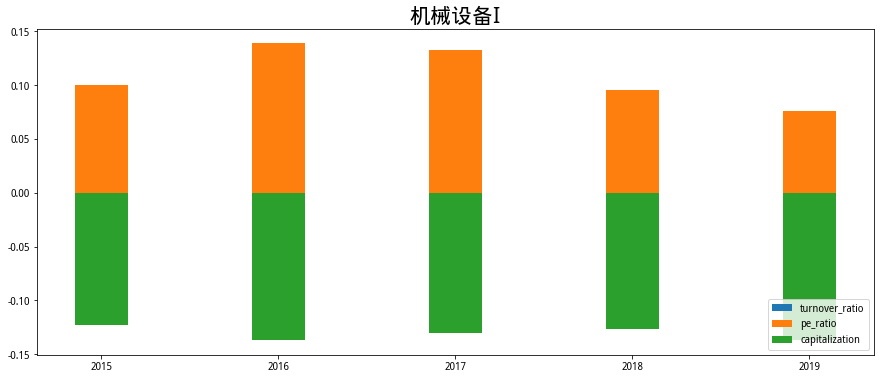

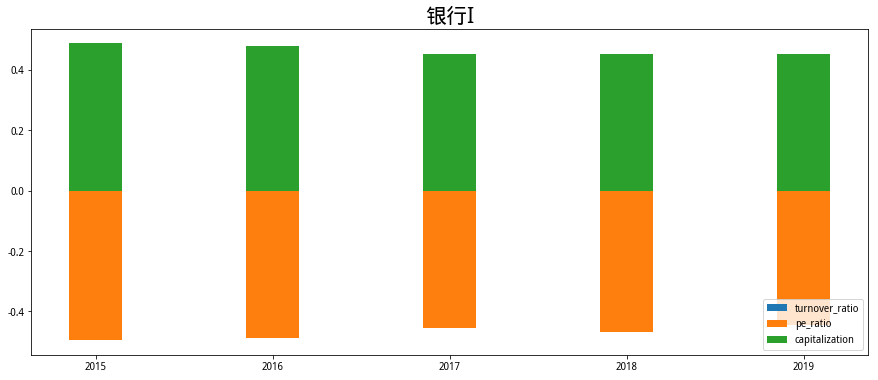

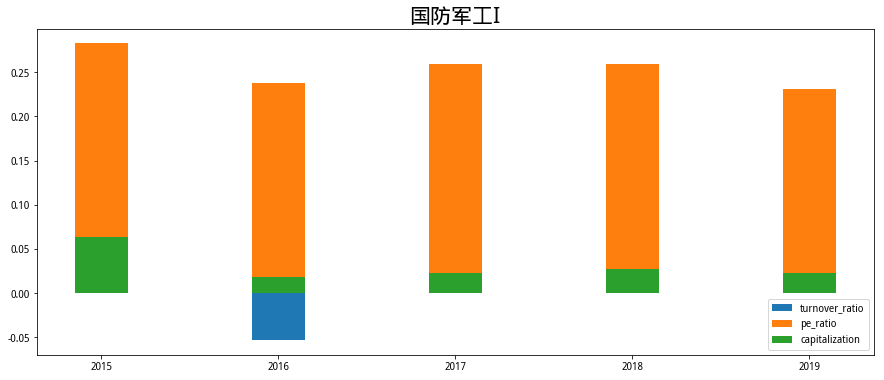

In [582]:
Year= ['2015','2016','2017','2018','2019']
Fields = ['turnover_ratio', 'pe_ratio', 'capitalization']
total1x = pd.DataFrame()
total2x = pd.DataFrame()
total3x = pd.DataFrame()
total4x = pd.DataFrame()

explore1=getExplore('801750')
explore2=getExplore('801890')
explore3=getExplore('801780')
explore4=getExplore('801740')

for i in range(len(Year)):
    total1x[Year[i]] = explore1.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    total2x[Year[i]] = explore2.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    total3x[Year[i]] = explore3.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    total4x[Year[i]] = explore4.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    
Fields01 = ['turnover_ratio', 'pe_ratio', 'capitalization']

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total1x.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("计算机I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total2x.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("机械设备I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total3x.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("银行I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total4x.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("国防军工I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()


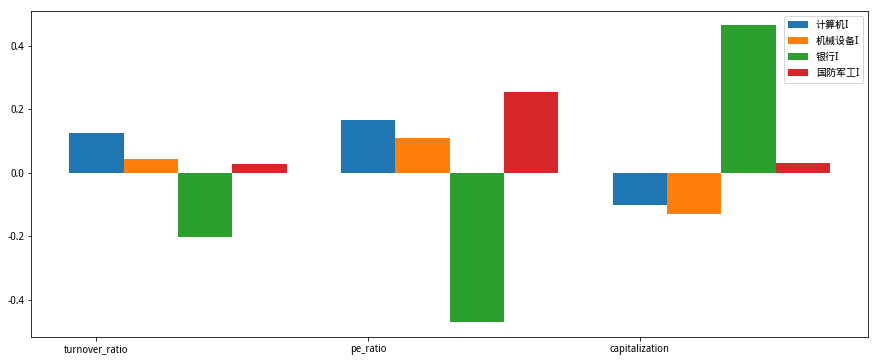

In [583]:
FieldsRe = ['turnover_ratio', 'pe_ratio', 'capitalization']
result_1 = []
result_2 = []
result_3 = []
result_4 = []

for i in Fields:
    result_1.append(explore1[i].mean())
    result_2.append(explore2[i].mean())
    result_3.append(explore3[i].mean())
    result_4.append(explore4[i].mean())
    
fig = plt.figure(figsize=(15,6))
bar_width = 0.2
x = np.array(range(len(result_1)))
plt.bar(x, result_1, bar_width, label = '计算机I')
plt.bar(x+bar_width*1, result_2, bar_width, label = '机械设备I')
plt.bar(x+bar_width*2, result_3, bar_width, label = '银行I')
plt.bar(x+bar_width*3, result_4, bar_width, label = '国防军工I')
plt.xticks(range(len(result_1)), FieldsRe)
# 添加图例
plt.legend()
plt.show()

# Part 2 

# 计算机I，turnover_ratio

In [584]:
pd.options.mode.chained_assignment = None 
#提取所有交易日列表
days=get_trade_days('2015-01-01','2020-01-11')
days=list(map(lambda x:str(x),days))
stocks=get_industry_stocks('801750') #计算机
stocks.remove('688555.XSHG')
months=[]
#---------－－－－－－－－－－－－－－－
# 取月度交易日，确保每月所取日期为交易日
#---------－－－－－－－－－－－－－－－
for i in range(len(days)-1):
    if days[i][5:7]!=days[i+1][5:7]:
        months.append(days[i])

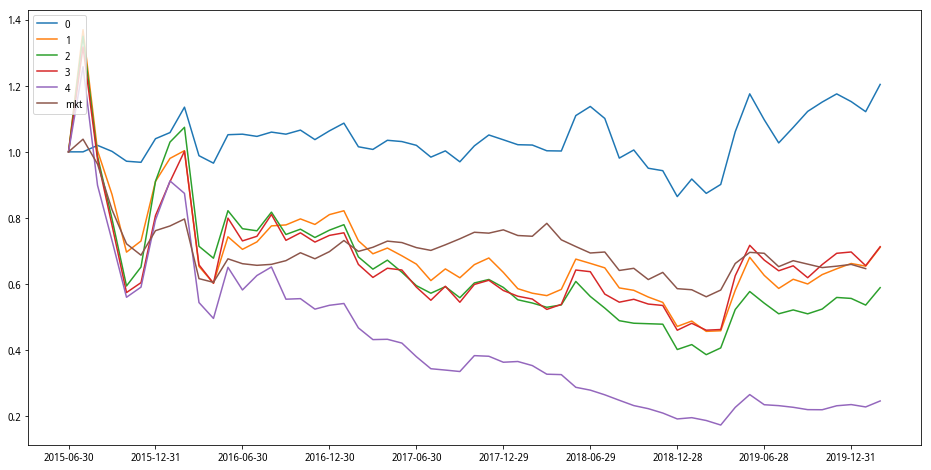

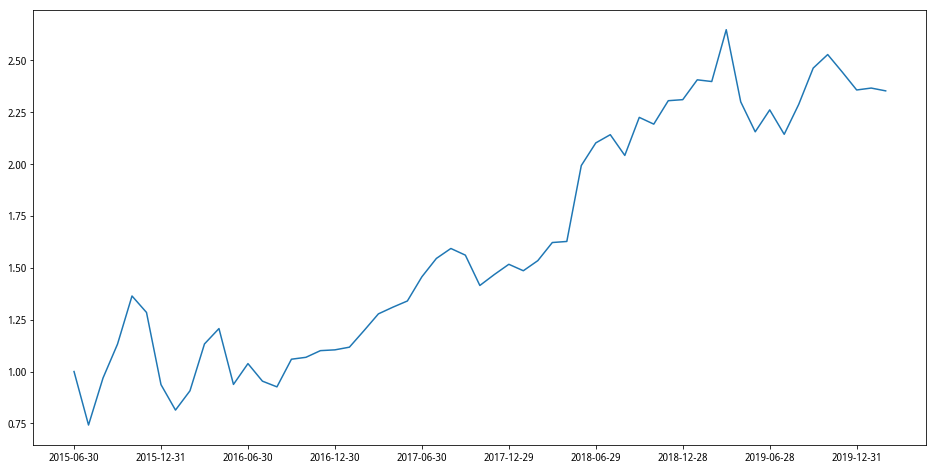

In [585]:
all_prices=[[1],[1],[1],[1],[1]]
q=query(valuation).filter(valuation.code.in_(stocks),valuation.pe_ratio>0)
mkt_price=[]
delta=[1]
for j in range(3,len(months)-1): 
    df=get_fundamentals(q,date=months[j]).sort_values('turnover_ratio')
    df.index=df.code.values
    df=df[['turnover_ratio','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices=get_price(stocks,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0=get_price(stocks,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0=list(vol0[vol0['volume']!=0].index)
    prices=prices.loc[vol0,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df['ret']=prices[months[j+1]]/prices[months[j]]-1
    df['ret_cap']=df['ret']*df['market_cap']
    five_df=list(df[int(len(df)*i/5):int(len(df)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices[i].append(all_prices[i][-1]*(1+sum(five_df[i]['ret_cap'])/sum(five_df[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas=list(all_prices[0][i]/all_prices[0][i-1]-all_prices[4][i]/all_prices[4][i-1] for i in range(1,len(all_prices[0])))
price_delta=[1]
for i in range(len(deltas)):
    price_delta.append(price_delta[-1]*(1+deltas[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta)
plt.xticks(xxx,xdate)
plt.show()

In [586]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices=pd.DataFrame()
for i in range(0,5):
    df_allprices[i]=all_prices[i]
df_allprices['0-4']=price_delta

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices['date']=mmm
df_allprices.set_index(df_allprices['date'],inplace=True)
df_allprices.drop(columns='date',axis=1,inplace=True)

df_allprices.columns=['zero','first','second','third','fourth','0-4']
results=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices.columns:
    results[i] = get_risk_index(df_allprices[i])
results.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.20,-0.29,-0.41,-0.29,-0.75,1.35
策略年化收益,0.04,-0.07,-0.11,-0.07,-0.26,0.20
夏普比率,-0.00,-0.27,-0.33,-0.24,-0.66,0.43
最大回撤,0.24,0.67,0.71,0.65,0.86,0.40
年化波动率,0.18,0.41,0.44,0.47,0.45,0.37


# 计算机I，pe_ratio

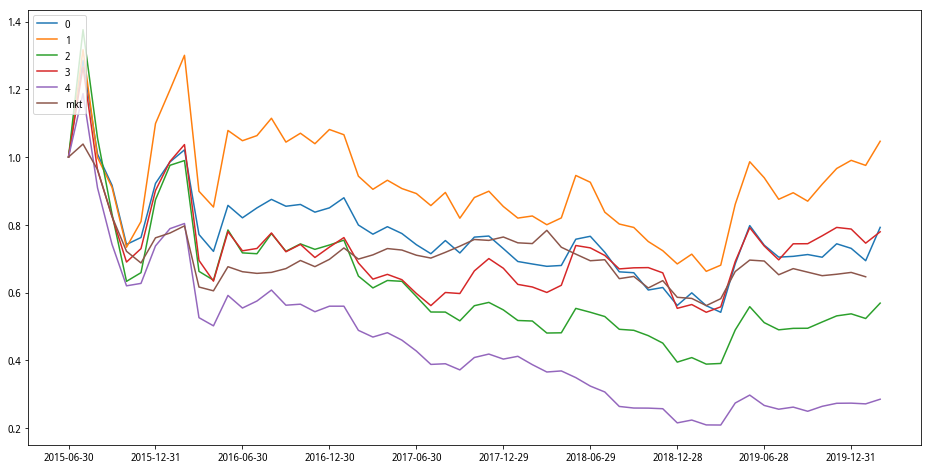

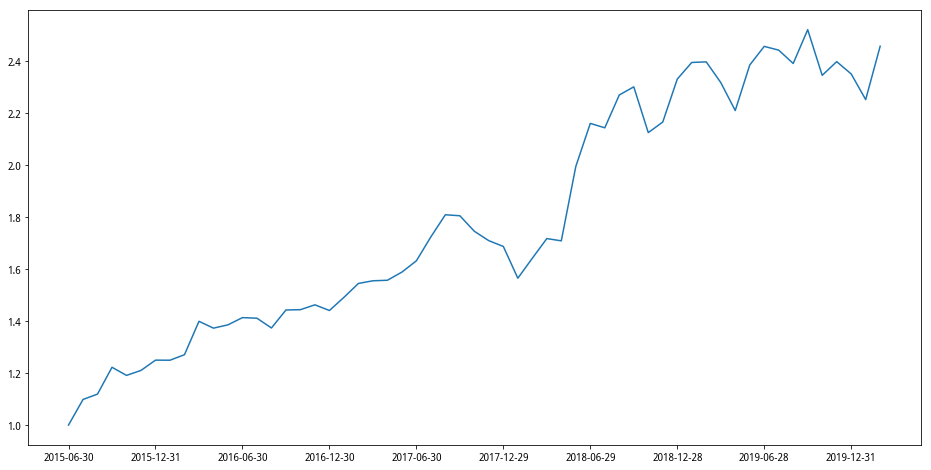

In [587]:
stocks2=get_industry_stocks('801750') #计算机I
stocks2.remove('688555.XSHG')
all_prices2=[[1],[1],[1],[1],[1]]
q2=query(valuation).filter(valuation.code.in_(stocks2),valuation.pe_ratio>0)
mkt_price=[]
delta2=[1]
for j in range(3,len(months)-1): 
    df2=get_fundamentals(q2,date=months[j]).sort_values('pe_ratio')
    df2.index=df2.code.values
    df2=df2[['pe_ratio','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices2=get_price(stocks2,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol02=get_price(stocks2,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol02=list(vol02[vol02['volume']!=0].index)
    prices2=prices2.loc[vol02,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df2['ret']=prices2[months[j+1]]/prices2[months[j]]-1
    df2['ret_cap']=df2['ret']*df2['market_cap']
    five_df2=list(df2[int(len(df2)*i/5):int(len(df2)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices2[i].append(all_prices2[i][-1]*(1+sum(five_df2[i]['ret_cap'])/sum(five_df2[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices2[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas2=list(all_prices2[0][i]/all_prices2[0][i-1]-all_prices2[4][i]/all_prices2[4][i-1] for i in range(1,len(all_prices2[0])))
price_delta2=[1]
for i in range(len(deltas2)):
    price_delta2.append(price_delta2[-1]*(1+deltas2[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta2)
plt.xticks(xxx,xdate)
plt.show()

In [588]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices2=pd.DataFrame()
for i in range(0,5):
    df_allprices2[i]=all_prices2[i]
df_allprices2['0-4']=price_delta2

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices2['date']=mmm
df_allprices2.set_index(df_allprices2['date'],inplace=True)
df_allprices2.drop(columns='date',axis=1,inplace=True)

df_allprices2.columns=['zero','first','second','third','fourth','0-4']
results2=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices2.columns:
    results2[i] = get_risk_index(df_allprices2[i])
results2.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,-0.21,0.05,-0.43,-0.22,-0.71,1.46
策略年化收益,-0.05,0.01,-0.11,-0.05,-0.23,0.21
夏普比率,-0.26,-0.08,-0.36,-0.24,-0.77,1.05
最大回撤,0.58,0.50,0.72,0.57,0.82,0.13
年化波动率,0.34,0.40,0.42,0.38,0.36,0.16


# 计算机I，总股本

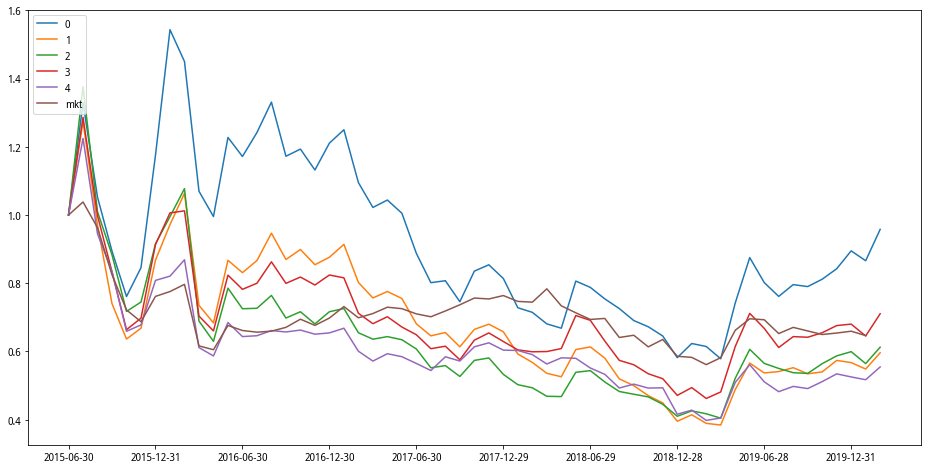

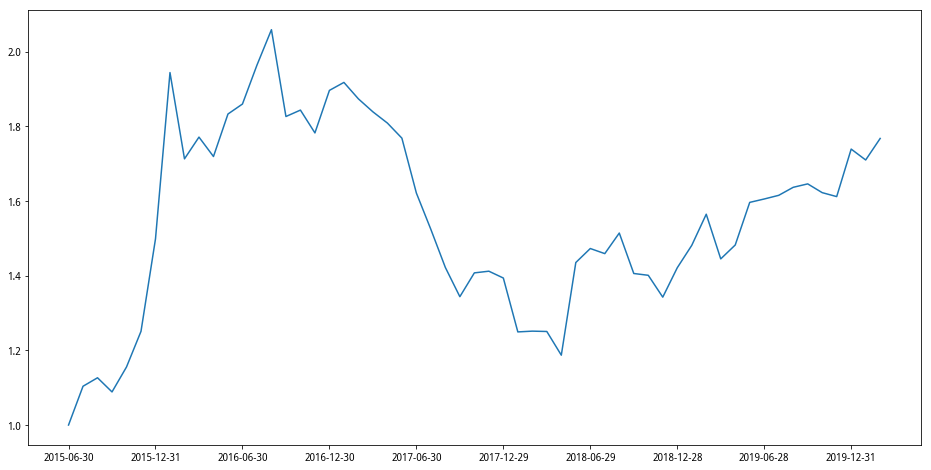

In [589]:
stocks_3=get_industry_stocks('801750') #计算机I
stocks_3.remove('688555.XSHG')
all_prices_3=[[1],[1],[1],[1],[1]]
q_3=query(valuation).filter(valuation.code.in_(stocks_3),valuation.pe_ratio>0)
mkt_price=[]
delta_3=[1]
for j in range(3,len(months)-1): 
    df_3=get_fundamentals(q_3,date=months[j]).sort_values('capitalization')
    df_3.index=df_3.code.values
    df_3=df_3[['capitalization','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_3=get_price(stocks_3,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_3=get_price(stocks_3,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_3=list(vol0_3[vol0_3['volume']!=0].index)
    prices_3=prices_3.loc[vol0_3,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_3['ret']=prices_3[months[j+1]]/prices_3[months[j]]-1
    df_3['ret_cap']=df_3['ret']*df_3['market_cap']
    five_df_3=list(df_3[int(len(df_3)*i/5):int(len(df_3)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_3[i].append(all_prices_3[i][-1]*(1+sum(five_df_3[i]['ret_cap'])/sum(five_df_3[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_3[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_3=list(all_prices_3[0][i]/all_prices_3[0][i-1]-all_prices_3[4][i]/all_prices_3[4][i-1] for i in range(1,len(all_prices_3[0])))
price_delta_3=[1]
for i in range(len(deltas_3)):
    price_delta_3.append(price_delta_3[-1]*(1+deltas_3[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_3)
plt.xticks(xxx,xdate)
plt.show()

In [590]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_3=pd.DataFrame()
for i in range(0,5):
    df_allprices_3[i]=all_prices_3[i]
df_allprices_3['0-4']=price_delta_3

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_3['date']=mmm
df_allprices_3.set_index(df_allprices_3['date'],inplace=True)
df_allprices_3.drop(columns='date',axis=1,inplace=True)

df_allprices_3.columns=['zero','first','second','third','fourth','0-4']
results_3=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_3.columns:
    results_3[i] = get_risk_index(df_allprices_3[i])
results_3.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,-0.04,-0.40,-0.39,-0.29,-0.45,0.77
策略年化收益,-0.01,-0.10,-0.10,-0.07,-0.12,0.13
夏普比率,-0.11,-0.35,-0.34,-0.28,-0.48,0.34
最大回撤,0.63,0.70,0.71,0.64,0.68,0.42
年化波动率,0.45,0.41,0.41,0.40,0.33,0.26


# 银行I，turnover_ratio

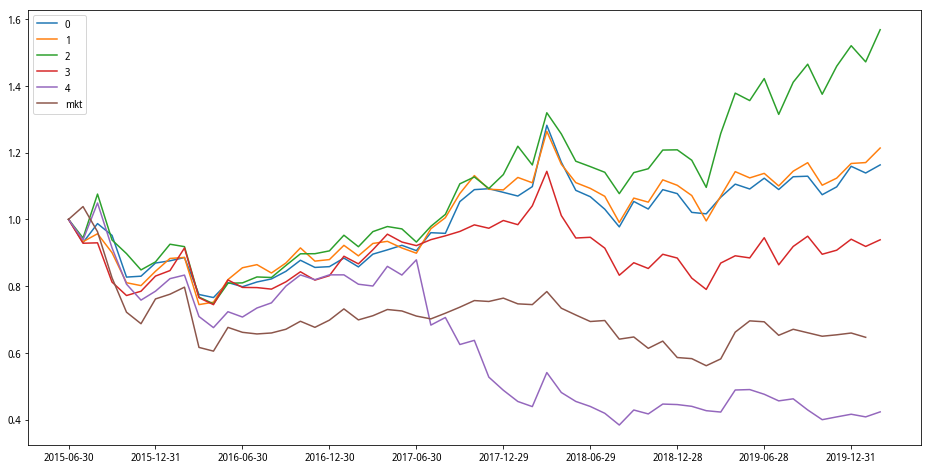

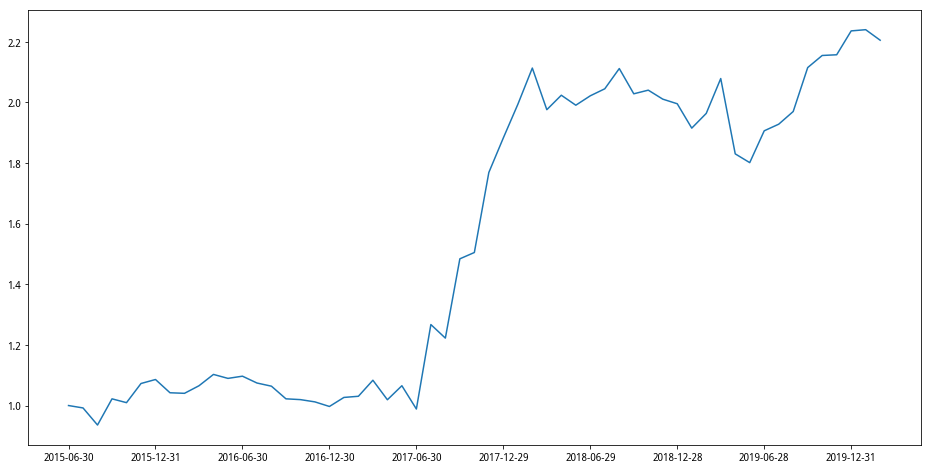

In [591]:
stocks_yh1=get_industry_stocks('801780') #银行
#stocks_yh1.remove('688555.XSHG')
all_prices_yh1=[[1],[1],[1],[1],[1]]
q_yh1=query(valuation).filter(valuation.code.in_(stocks_yh1),valuation.pe_ratio>0)
mkt_price=[]
delta_yh1=[1]
for j in range(3,len(months)-1): 
    df_yh1=get_fundamentals(q_yh1,date=months[j]).sort_values('turnover_ratio')
    df_yh1.index=df_yh1.code.values
    df_yh1=df_yh1[['turnover_ratio','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_yh1=get_price(stocks_yh1,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_yh1=get_price(stocks_yh1,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_yh1=list(vol0_yh1[vol0_yh1['volume']!=0].index)
    prices_yh1=prices_yh1.loc[vol0_yh1,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_yh1['ret']=prices_yh1[months[j+1]]/prices_yh1[months[j]]-1
    df_yh1['ret_cap']=df_yh1['ret']*df_yh1['market_cap']
    five_df_yh1=list(df_yh1[int(len(df_yh1)*i/5):int(len(df_yh1)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_yh1[i].append(all_prices_yh1[i][-1]*(1+sum(five_df_yh1[i]['ret_cap'])/sum(five_df_yh1[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_yh1[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_yh1=list(all_prices_yh1[0][i]/all_prices_yh1[0][i-1]-all_prices_yh1[4][i]/all_prices_yh1[4][i-1] for i in range(1,len(all_prices_yh1[0])))
price_delta_yh1=[1]
for i in range(len(deltas_yh1)):
    price_delta_yh1.append(price_delta_yh1[-1]*(1+deltas_yh1[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_yh1)
plt.xticks(xxx,xdate)
plt.show()

In [592]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_yh1=pd.DataFrame()
for i in range(0,5):
    df_allprices_yh1[i]=all_prices_yh1[i]
df_allprices_yh1['0-4']=price_delta_yh1

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_yh1['date']=mmm
df_allprices_yh1.set_index(df_allprices_yh1['date'],inplace=True)
df_allprices_yh1.drop(columns='date',axis=1,inplace=True)

df_allprices_yh1.columns=['zero','first','second','third','fourth','0-4']
results_yh1=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_yh1.columns:
    results_yh1[i] = get_risk_index(df_allprices_yh1[i])
results_yh1.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.16,0.21,0.57,-0.06,-0.58,1.21
策略年化收益,0.03,0.04,0.10,-0.01,-0.17,0.18
夏普比率,-0.04,0.01,0.28,-0.28,-0.76,0.64
最大回撤,0.24,0.26,0.31,0.31,0.63,0.15
年化波动率,0.18,0.19,0.22,0.19,0.27,0.22


# 银行I，pe_ratio

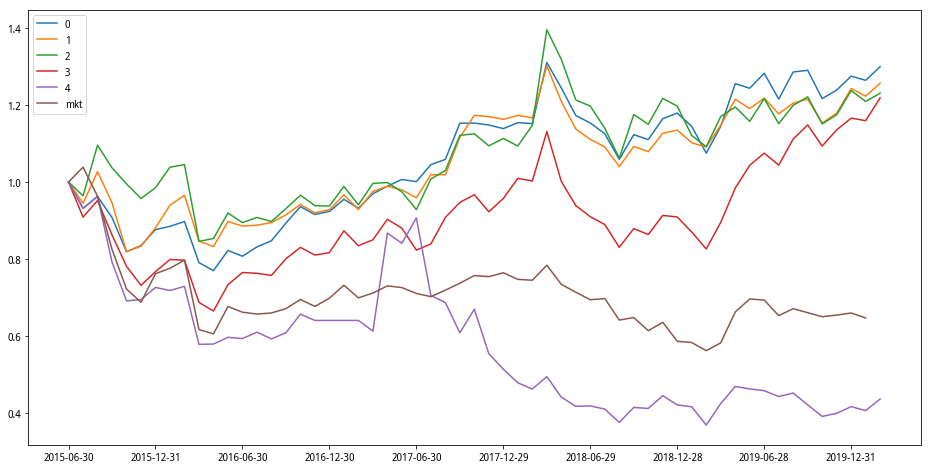

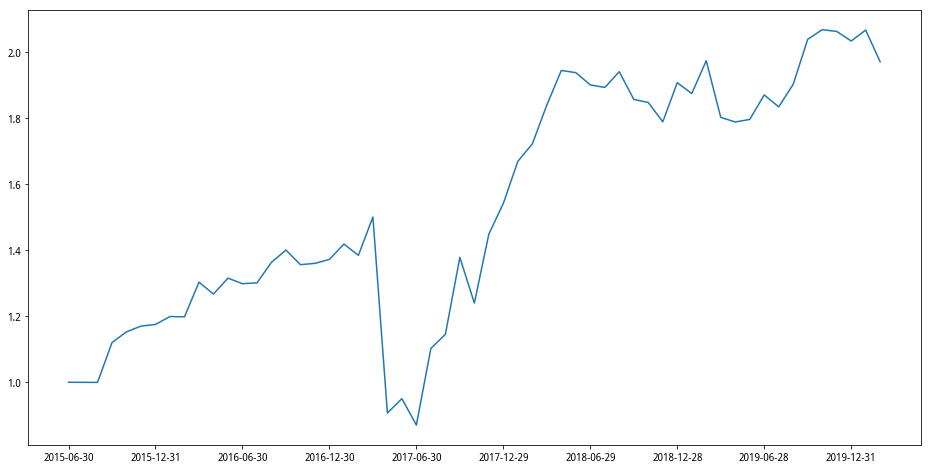

In [593]:
stocks_yh2=get_industry_stocks('801780') #银行
#stocks_yh2.remove('688555.XSHG')
all_prices_yh2=[[1],[1],[1],[1],[1]]
q_yh2=query(valuation).filter(valuation.code.in_(stocks_yh2),valuation.pe_ratio>0)
mkt_price=[]
delta_yh2=[1]
for j in range(3,len(months)-1): 
    df_yh2=get_fundamentals(q_yh2,date=months[j]).sort_values('pe_ratio')
    df_yh2.index=df_yh2.code.values
    df_yh2=df_yh2[['pe_ratio','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_yh2=get_price(stocks_yh2,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_yh2=get_price(stocks_yh2,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_yh2=list(vol0_yh2[vol0_yh2['volume']!=0].index)
    prices_yh2=prices_yh2.loc[vol0_yh2,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_yh2['ret']=prices_yh2[months[j+1]]/prices_yh2[months[j]]-1
    df_yh2['ret_cap']=df_yh2['ret']*df_yh2['market_cap']
    five_df_yh2=list(df_yh2[int(len(df_yh2)*i/5):int(len(df_yh2)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_yh2[i].append(all_prices_yh2[i][-1]*(1+sum(five_df_yh2[i]['ret_cap'])/sum(five_df_yh2[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_yh2[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_yh2=list(all_prices_yh2[0][i]/all_prices_yh2[0][i-1]-all_prices_yh2[4][i]/all_prices_yh2[4][i-1] for i in range(1,len(all_prices_yh2[0])))
price_delta_yh2=[1]
for i in range(len(deltas_yh2)):
    price_delta_yh2.append(price_delta_yh2[-1]*(1+deltas_yh2[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_yh2)
plt.xticks(xxx,xdate)
plt.show()

In [594]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_yh2=pd.DataFrame()
for i in range(0,5):
    df_allprices_yh2[i]=all_prices_yh2[i]
df_allprices_yh2['0-4']=price_delta_yh2

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_yh2['date']=mmm
df_allprices_yh2.set_index(df_allprices_yh2['date'],inplace=True)
df_allprices_yh2.drop(columns='date',axis=1,inplace=True)

df_allprices_yh2.columns=['zero','first','second','third','fourth','0-4']
results_yh2=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_yh2.columns:
    results_yh2[i] = get_risk_index(df_allprices_yh2[i])
results_yh2.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.30,0.26,0.23,0.22,-0.56,0.97
策略年化收益,0.06,0.05,0.04,0.04,-0.16,0.15
夏普比率,0.10,0.05,0.02,0.01,-0.60,0.39
最大回撤,0.23,0.20,0.24,0.34,0.63,0.42
年化波动率,0.17,0.17,0.21,0.20,0.33,0.29


# 银行I，总股本

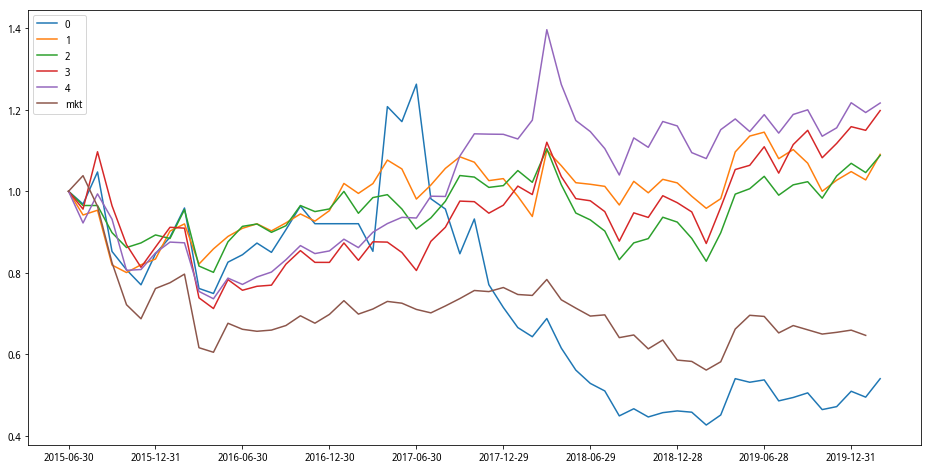

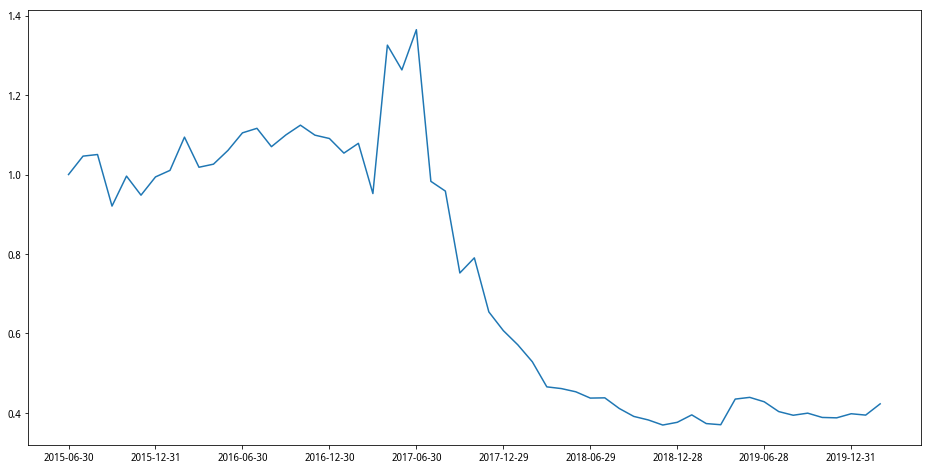

In [595]:
stocks_yh3=get_industry_stocks('801780') #银行
#stocks_yh3.remove('688555.XSHG')
all_prices_yh3=[[1],[1],[1],[1],[1]]
q_yh3=query(valuation).filter(valuation.code.in_(stocks_yh3),valuation.pe_ratio>0)
mkt_price=[]
delta_yh3=[1]
for j in range(3,len(months)-1): 
    df_yh3=get_fundamentals(q_yh3,date=months[j]).sort_values('capitalization')
    df_yh3.index=df_yh3.code.values
    df_yh3=df_yh3[['capitalization','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_yh3=get_price(stocks_yh3,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_yh3=get_price(stocks_yh3,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_yh3=list(vol0_yh3[vol0_yh3['volume']!=0].index)
    prices_yh3=prices_yh3.loc[vol0_yh3,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_yh3['ret']=prices_yh3[months[j+1]]/prices_yh3[months[j]]-1
    df_yh3['ret_cap']=df_yh3['ret']*df_yh3['market_cap']
    five_df_yh3=list(df_yh3[int(len(df_yh3)*i/5):int(len(df_yh3)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_yh3[i].append(all_prices_yh3[i][-1]*(1+sum(five_df_yh3[i]['ret_cap'])/sum(five_df_yh3[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_yh3[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_yh3=list(all_prices_yh3[0][i]/all_prices_yh3[0][i-1]-all_prices_yh3[4][i]/all_prices_yh3[4][i-1] for i in range(1,len(all_prices_yh3[0])))
price_delta_yh3=[1]
for i in range(len(deltas_yh3)):
    price_delta_yh3.append(price_delta_yh3[-1]*(1+deltas_yh3[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_yh3)
plt.xticks(xxx,xdate)
plt.show()

In [596]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_yh3=pd.DataFrame()
for i in range(0,5):
    df_allprices_yh3[i]=all_prices_yh3[i]
df_allprices_yh3['0-4']=price_delta_yh3

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_yh3['date']=mmm
df_allprices_yh3.set_index(df_allprices_yh3['date'],inplace=True)
df_allprices_yh3.drop(columns='date',axis=1,inplace=True)

df_allprices_yh3.columns=['zero','first','second','third','fourth','0-4']
results_yh3=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_yh3.columns:
    results_yh3[i] = get_risk_index(df_allprices_yh3[i])
results_yh3.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,-0.46,0.09,0.09,0.20,0.22,-0.58
策略年化收益,-0.12,0.02,0.02,0.04,0.04,-0.17
夏普比率,-0.47,-0.12,-0.13,-0.01,0.01,-0.65
最大回撤,0.66,0.20,0.25,0.35,0.26,0.73
年化波动率,0.35,0.18,0.17,0.22,0.19,0.32


# 国防军工I，turnover_ratio

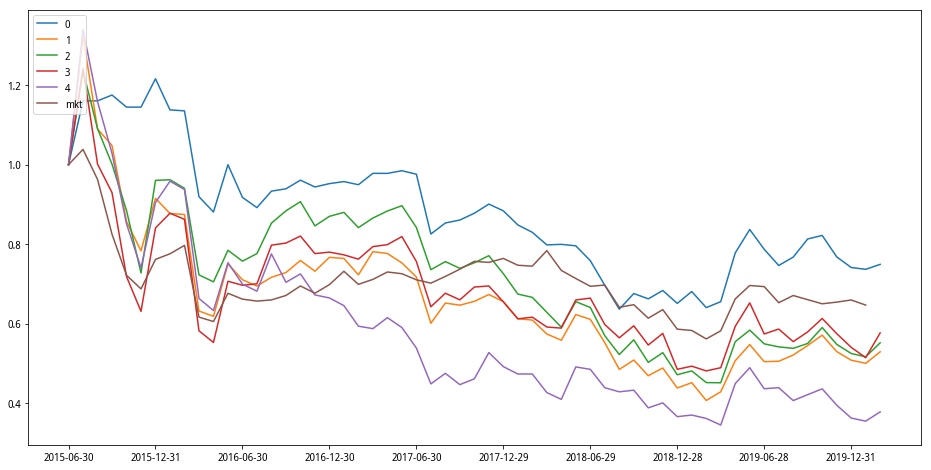

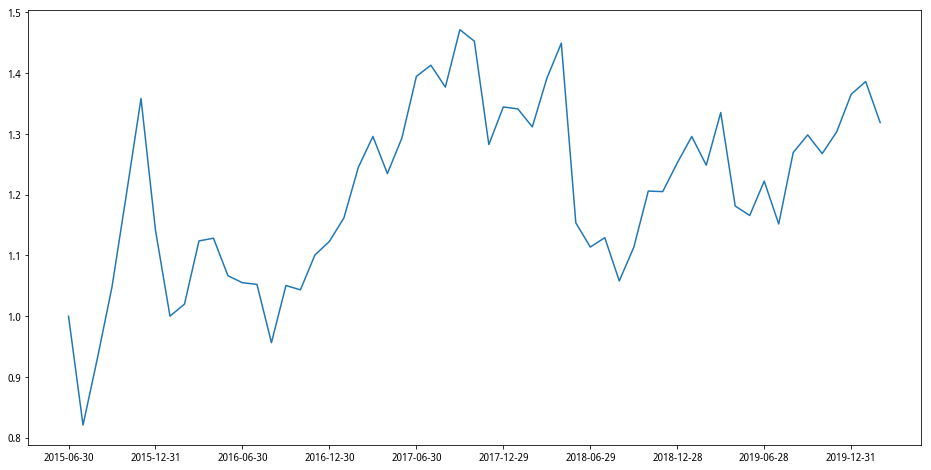

In [597]:
stocks_gf1=get_industry_stocks('801740') #国防军工I
#stocks_gf1.remove('688555.XSHG')
all_prices_gf1=[[1],[1],[1],[1],[1]]
q_gf1=query(valuation).filter(valuation.code.in_(stocks_gf1),valuation.pe_ratio>0)
mkt_price=[]
delta_gf1=[1]
for j in range(3,len(months)-1): 
    df_gf1=get_fundamentals(q_gf1,date=months[j]).sort_values('turnover_ratio')
    df_gf1.index=df_gf1.code.values
    df_gf1=df_gf1[['turnover_ratio','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_gf1=get_price(stocks_gf1,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_gf1=get_price(stocks_gf1,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_gf1=list(vol0_gf1[vol0_gf1['volume']!=0].index)
    prices_gf1=prices_gf1.loc[vol0_gf1,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_gf1['ret']=prices_gf1[months[j+1]]/prices_gf1[months[j]]-1
    df_gf1['ret_cap']=df_gf1['ret']*df_gf1['market_cap']
    five_df_gf1=list(df_gf1[int(len(df_gf1)*i/5):int(len(df_gf1)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_gf1[i].append(all_prices_gf1[i][-1]*(1+sum(five_df_gf1[i]['ret_cap'])/sum(five_df_gf1[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_gf1[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_gf1=list(all_prices_gf1[0][i]/all_prices_gf1[0][i-1]-all_prices_gf1[4][i]/all_prices_gf1[4][i-1] for i in range(1,len(all_prices_gf1[0])))
price_delta_gf1=[1]
for i in range(len(deltas_gf1)):
    price_delta_gf1.append(price_delta_gf1[-1]*(1+deltas_gf1[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_gf1)
plt.xticks(xxx,xdate)
plt.show()

In [598]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_gf1=pd.DataFrame()
for i in range(0,5):
    df_allprices_gf1[i]=all_prices_gf1[i]
df_allprices_gf1['0-4']=price_delta_gf1

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_gf1['date']=mmm
df_allprices_gf1.set_index(df_allprices_gf1['date'],inplace=True)
df_allprices_gf1.drop(columns='date',axis=1,inplace=True)

df_allprices_gf1.columns=['zero','first','second','third','fourth','0-4']
results_gf1=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_gf1.columns:
    results_gf1[i] = get_risk_index(df_allprices_gf1[i])
results_gf1.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,-0.25,-0.47,-0.45,-0.42,-0.62,0.32
策略年化收益,-0.06,-0.13,-0.12,-0.11,-0.19,0.06
夏普比率,-0.46,-0.49,-0.49,-0.38,-0.58,0.08
最大回撤,0.48,0.69,0.63,0.61,0.74,0.30
年化波动率,0.22,0.34,0.33,0.39,0.39,0.27


# 国防军工I，pe_ratio

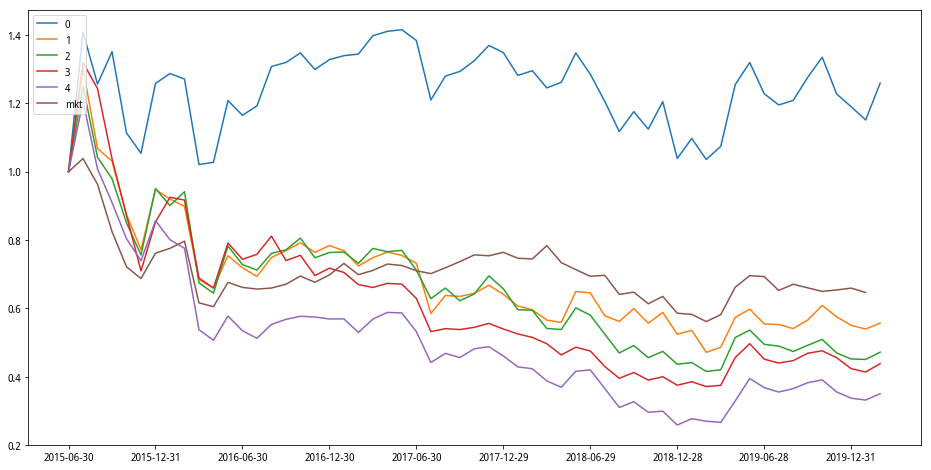

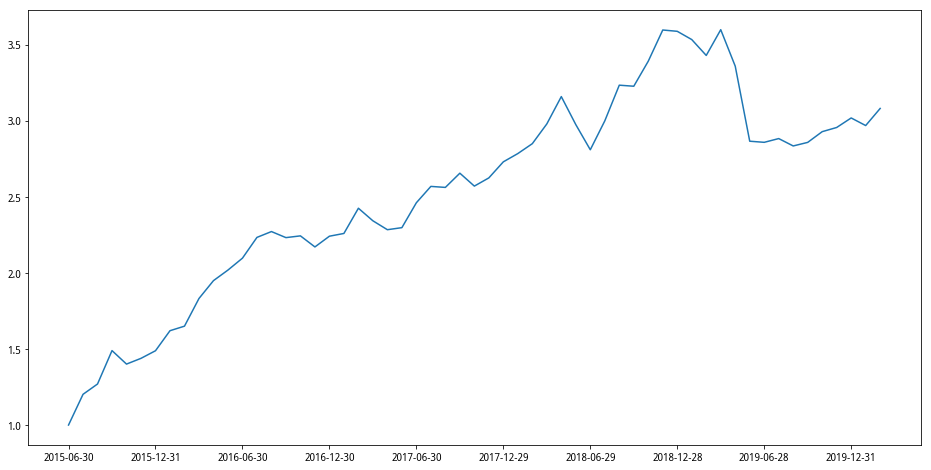

In [599]:
stocks_gf2=get_industry_stocks('801740') #国防军工I
#stocks_gf2.remove('688555.XSHG')
all_prices_gf2=[[1],[1],[1],[1],[1]]
q_gf2=query(valuation).filter(valuation.code.in_(stocks_gf2),valuation.pe_ratio>0)
mkt_price=[]
delta_gf2=[1]
for j in range(3,len(months)-1): 
    df_gf2=get_fundamentals(q_gf2,date=months[j]).sort_values('pe_ratio')
    df_gf2.index=df_gf2.code.values
    df_gf2=df_gf2[['pe_ratio','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_gf2=get_price(stocks_gf2,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_gf2=get_price(stocks_gf2,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_gf2=list(vol0_gf2[vol0_gf2['volume']!=0].index)
    prices_gf2=prices_gf2.loc[vol0_gf2,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_gf2['ret']=prices_gf2[months[j+1]]/prices_gf2[months[j]]-1
    df_gf2['ret_cap']=df_gf2['ret']*df_gf2['market_cap']
    five_df_gf2=list(df_gf2[int(len(df_gf2)*i/5):int(len(df_gf2)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_gf2[i].append(all_prices_gf2[i][-1]*(1+sum(five_df_gf2[i]['ret_cap'])/sum(five_df_gf2[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_gf2[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_gf2=list(all_prices_gf2[0][i]/all_prices_gf2[0][i-1]-all_prices_gf2[4][i]/all_prices_gf2[4][i-1] for i in range(1,len(all_prices_gf2[0])))
price_delta_gf2=[1]
for i in range(len(deltas_gf2)):
    price_delta_gf2.append(price_delta_gf2[-1]*(1+deltas_gf2[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_gf2)
plt.xticks(xxx,xdate)
plt.show()

In [600]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_gf2=pd.DataFrame()
for i in range(0,5):
    df_allprices_gf2[i]=all_prices_gf2[i]
df_allprices_gf2['0-4']=price_delta_gf2

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol


mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_gf2['date']=mmm
df_allprices_gf2.set_index(df_allprices_gf2['date'],inplace=True)
df_allprices_gf2.drop(columns='date',axis=1,inplace=True)

df_allprices_gf2.columns=['zero','first','second','third','fourth','0-4']
results_gf2=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_gf2.columns:
    results_gf2[i] = get_risk_index(df_allprices_gf2[i])
results_gf2.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.26,-0.44,-0.53,-0.56,-0.65,2.08
策略年化收益,0.05,-0.12,-0.15,-0.16,-0.20,0.27
夏普比率,0.03,-0.48,-0.56,-0.60,-0.70,1.20
最大回撤,0.27,0.64,0.67,0.72,0.79,0.21
年化波动率,0.32,0.33,0.34,0.33,0.34,0.19


# 国防军工I，总股本

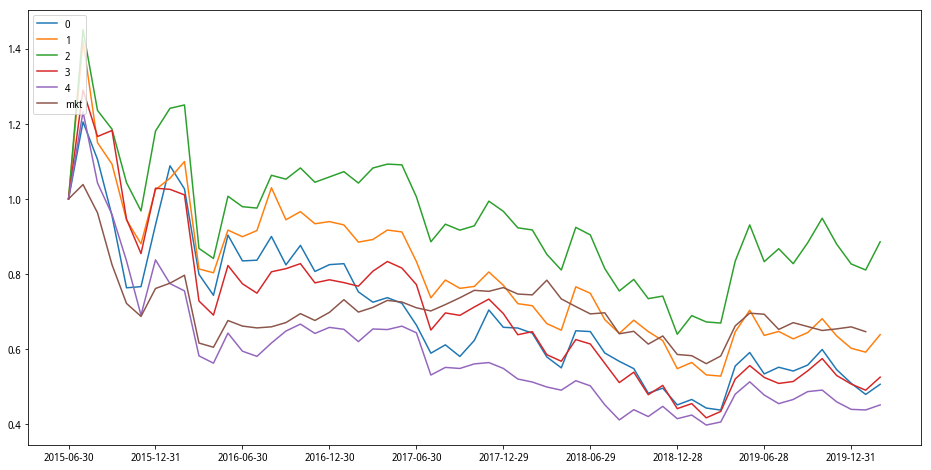

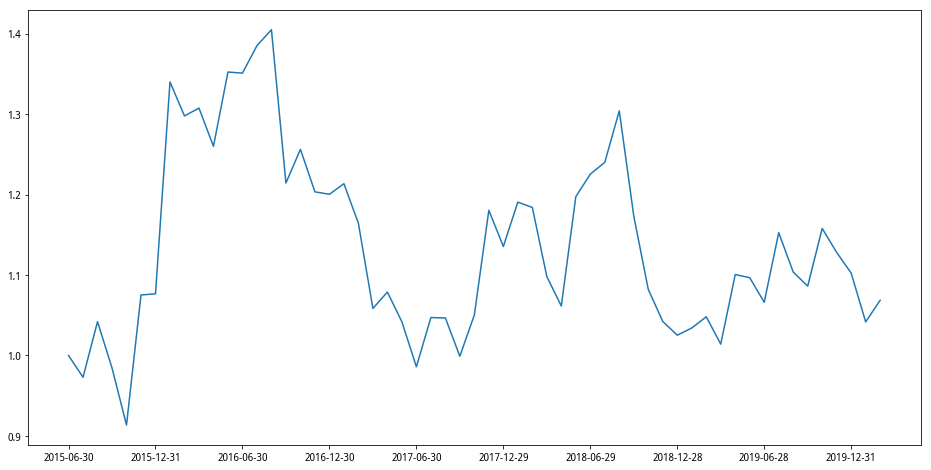

In [601]:
stocks_gf3=get_industry_stocks('801740') #国防军工I
#stocks_gf3.remove('688555.XSHG')
all_prices_gf3=[[1],[1],[1],[1],[1]]
q_gf3=query(valuation).filter(valuation.code.in_(stocks_gf3),valuation.pe_ratio>0)
mkt_price=[]
delta_gf3=[1]
for j in range(3,len(months)-1): 
    df_gf3=get_fundamentals(q_gf3,date=months[j]).sort_values('capitalization')
    df_gf3.index=df_gf3.code.values
    df_gf3=df_gf3[['capitalization','market_cap']]
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_gf3=get_price(stocks_gf3,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_gf3=get_price(stocks_gf3,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_gf3=list(vol0_gf3[vol0_gf3['volume']!=0].index)
    prices_gf3=prices_gf3.loc[vol0_gf3,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_gf3['ret']=prices_gf3[months[j+1]]/prices_gf3[months[j]]-1
    df_gf3['ret_cap']=df_gf3['ret']*df_gf3['market_cap']
    five_df_gf3=list(df_gf3[int(len(df_gf3)*i/5):int(len(df_gf3)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_gf3[i].append(all_prices_gf3[i][-1]*(1+sum(five_df_gf3[i]['ret_cap'])/sum(five_df_gf3[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_gf3[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_gf3=list(all_prices_gf3[0][i]/all_prices_gf3[0][i-1]-all_prices_gf3[4][i]/all_prices_gf3[4][i-1] for i in range(1,len(all_prices_gf3[0])))
price_delta_gf3=[1]
for i in range(len(deltas_gf3)):
    price_delta_gf3.append(price_delta_gf3[-1]*(1+deltas_gf3[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_gf3)
plt.xticks(xxx,xdate)
plt.show()

In [602]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_gf3=pd.DataFrame()
for i in range(0,5):
    df_allprices_gf3[i]=all_prices_gf3[i]
df_allprices_gf3['0-4']=price_delta_gf3

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_gf3['date']=mmm
df_allprices_gf3.set_index(df_allprices_gf3['date'],inplace=True)
df_allprices_gf3.drop(columns='date',axis=1,inplace=True)

df_allprices_gf3.columns=['zero','first','second','third','fourth','0-4']
results_gf3=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_gf3.columns:
    results_gf3[i] = get_risk_index(df_allprices_gf3[i])
results_gf3.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,-0.49,-0.36,-0.11,-0.47,-0.55,0.07
策略年化收益,-0.13,-0.09,-0.03,-0.13,-0.15,0.01
夏普比率,-0.50,-0.37,-0.17,-0.50,-0.66,-0.11
最大回撤,0.64,0.63,0.56,0.68,0.68,0.30
年化波动率,0.35,0.36,0.38,0.33,0.30,0.23


# 去极值、标准化、中性化

In [603]:
#去极值函数
#mad中位数去极值法
def filter_extreme_MAD(series,n): #MAD: 中位数去极值 
    median = series.quantile(0.5)
    new_median = ((series - median).abs()).quantile(0.50)
    max_range = median + n*new_median
    min_range = median - n*new_median
    return np.clip(series,min_range,max_range)

#标准化函数：
def standardize(s,ty=2):
    '''
    s为Series数据
    ty为标准化类型:1 MinMax,2 Standard,3 maxabs 
    '''
    data=s.dropna().copy()
    if int(ty)==1:
        re = (data - data.min())/(data.max() - data.min())
    elif ty==2:
        re = (data - data.mean())/data.std()
    elif ty==3:
        re = data/10**np.ceil(np.log10(data.abs().max()))
    return re

In [604]:
factor_list=['turnover_ratio','pe_ratio','capitalization']
pl = pd.Panel(factorData)
pl = pl.transpose(2,0,1)
#保留原始数据，方便后面修改使用
pl_pro = pl.copy()

#进行因子截面去极值、标准化处理
start = time.time()
print('计算%s截面去极值、标准化因子中......'%len(pl_pro.minor_axis))

for factor in factor_list[1:]:
    factor_df = pl_pro.loc[factor,:,:].copy() #获取因子df
    for i in factor_df.index:
        factor_df.loc[i,:] = filter_extreme_MAD(factor_df.loc[i,:],3)#去极值 
        factor_df.loc[i,:] = standardize(factor_df.loc[i,:],ty=2)    #标准化
    pl_pro[factor] = pd.DataFrame(factor_df,index=pl_pro.major_axis, columns=pl_pro.minor_axis)
    print('%s因子处理完毕'%factor)
end = time.time()
print('因子标准化处理完毕,统计股票个数：%s,耗时：%s 秒'%(len(pl_pro.minor_axis),end-start))
pl_pro

#获得行业哑变量矩阵
start = time.time()
print('中性化处理中......')
from jqdata import *
sw=get_industries(name='sw_l1').index
industry_df=pd.DataFrame(0,columns=pl_pro.minor_axis,index=range(len(sw)))

for i in range(len(sw)):
    temp=list(set(pl_pro.minor_axis).intersection(set(get_industry_stocks(sw[i])))) #?
    industry_df.loc[i,temp]=1
for factor in factor_list[1:]:
    data = pl_pro.loc[factor,:,:].copy()
    data = data.applymap(lambda x:float(x))

    #去除市值、行业因素，得到新的因子值 
    data_df=pd.DataFrame()
    for i in range(len(data.index)):
        
        #市值中性化
        m= get_fundamentals(query(valuation.circulating_market_cap,valuation.code).filter(valuation.code.in_(data.columns)), date=data.index[i])
        m.index=np.array(m['code'])
        m=m.iloc[:,0]
        m=(m-mean(m))/std(m)
        
        #行业中性化
        x=data.iloc[i,:]
        conc=pd.concat([x,m,industry_df.T],axis=1).fillna(mean(m)) 
        est=sm.OLS(conc.iloc[:,:1],conc.iloc[:,1:]).fit()
        y_fitted = est.fittedvalues
        data_df[i]=est.resid
        
    data_df=data_df.T
    data_df.index=data.index
    pl_pro[factor] = data_df
    print('%s中性化处理完毕'%factor)
end = time.time()
print('中性化处理完毕，耗时：%s 秒'%(end-start))
pl_pro=pl_pro.transpose(1,2,0)

计算3712截面去极值、标准化因子中......
pe_ratio因子处理完毕
capitalization因子处理完毕
因子标准化处理完毕,统计股票个数：3712,耗时：1.1490061283111572 秒
中性化处理中......
pe_ratio中性化处理完毕
capitalization中性化处理完毕
中性化处理完毕，耗时：45.62340521812439 秒


In [605]:
def getExplore2(index):
    explore = pd.DataFrame(index = TradeDate)
    for i in Fields: # Fields: different financial factors
        tempExplore = []
        for date in TradeDate:
            stockList = get_industry_stocks(index, date)
            temp = pl_pro[date][[i]]
            temp = temp.sort_values([i],ascending = False)
            temp['rank'] = range(len(temp)+1, 1, -1)
            # 获取行业股票在全市场股票中的平均排位
            tempExplore.append((temp.loc[stockList,'rank'].mean() - len(temp) / 2) / len(temp))
        explore[i] = tempExplore
    return explore

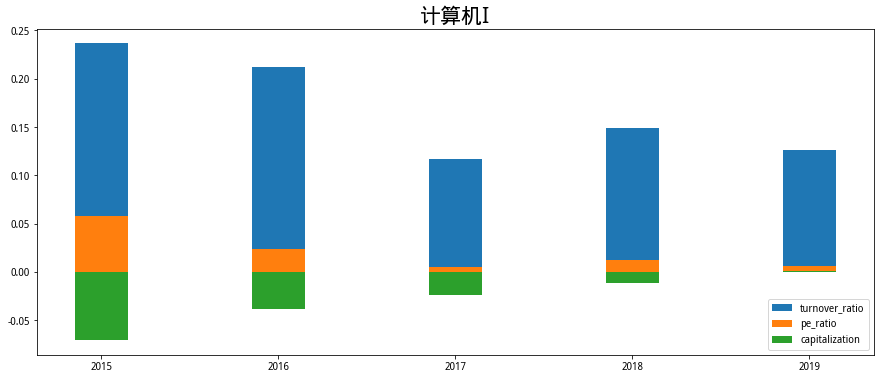

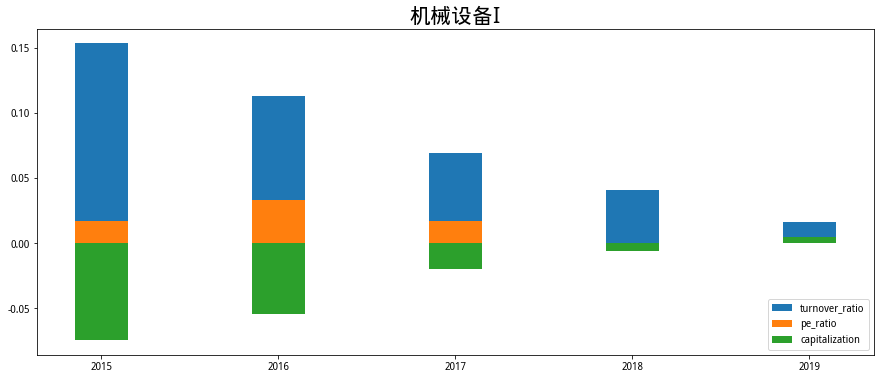

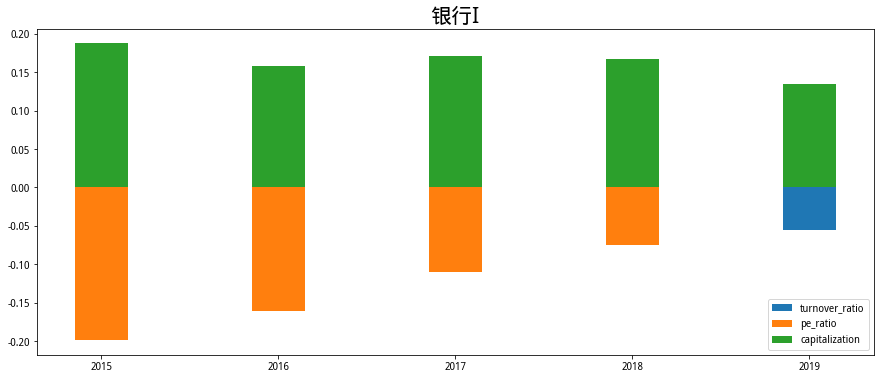

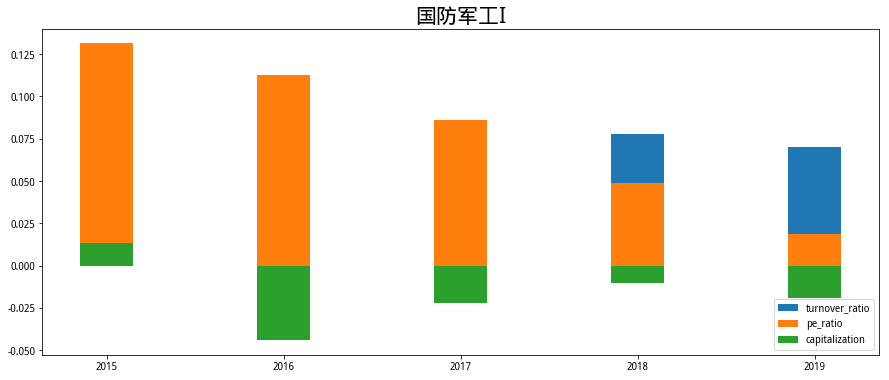

In [606]:
Year= ['2015','2016','2017','2018','2019']
Fields = ['turnover_ratio', 'pe_ratio', 'capitalization']
total1x2 = pd.DataFrame()
total2x2 = pd.DataFrame()
total3x2 = pd.DataFrame()
total4x2 = pd.DataFrame()

explore11=getExplore2('801750')
explore22=getExplore2('801890')
explore33=getExplore2('801780')
explore44=getExplore2('801740')

for i in range(len(Year)):
    total1x2[Year[i]] = explore11.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    total2x2[Year[i]] = explore22.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    total3x2[Year[i]] = explore33.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    total4x2[Year[i]] = explore44.iloc[round(i*len(explore1)/5):round((i+1)*len(explore1)/5),:].mean()
    
Fields01 = ['turnover_ratio', 'pe_ratio', 'capitalization']

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total1x2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("计算机I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total2x2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("机械设备I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total3x2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("银行I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()

x = np.array(range(len(Year)))
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
for i in Fields01:
    plt.bar(x, total4x2.loc[i], 0.3, label = i)
plt.xticks(range(len(Year)), Year)
ax.set_title("国防军工I", fontsize=21)
# 添加图例
plt.legend(loc=4)
plt.show()


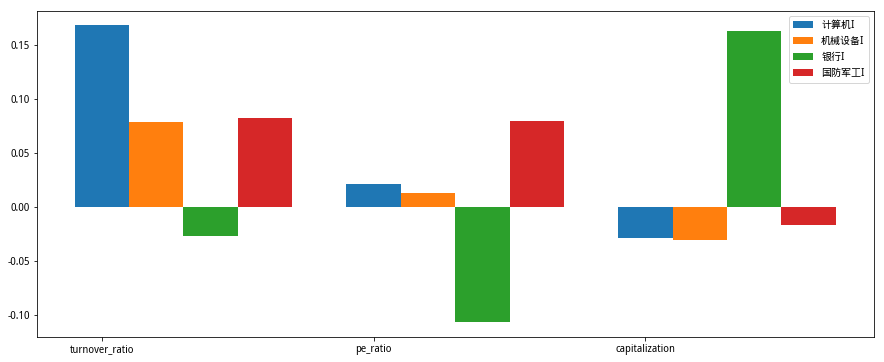

In [607]:
FieldsRe = ['turnover_ratio', 'pe_ratio', 'capitalization']
result_11 = []
result_22 = []
result_33 = []
result_44 = []

for i in Fields:
    result_11.append(explore11[i].mean())
    result_22.append(explore22[i].mean())
    result_33.append(explore33[i].mean())
    result_44.append(explore44[i].mean())
    
fig = plt.figure(figsize=(15,6))
bar_width = 0.2
x = np.array(range(len(result_1)))
plt.bar(x, result_11, bar_width, label = '计算机I')
plt.bar(x+bar_width*1, result_22, bar_width, label = '机械设备I')
plt.bar(x+bar_width*2, result_33, bar_width, label = '银行I')
plt.bar(x+bar_width*3, result_44, bar_width, label = '国防军工I')
plt.xticks(range(len(result_11)), FieldsRe)
# 添加图例
plt.legend()
plt.show()

In [608]:
for i in range(len(months)):
    pl_pro[months[i]]['code']=pl_pro[months[i]].index.values

# 计算机I
turnover_ratio

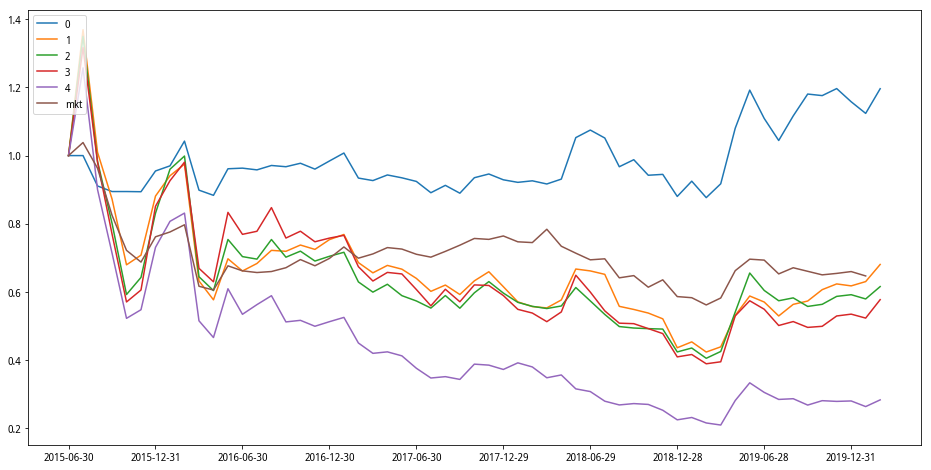

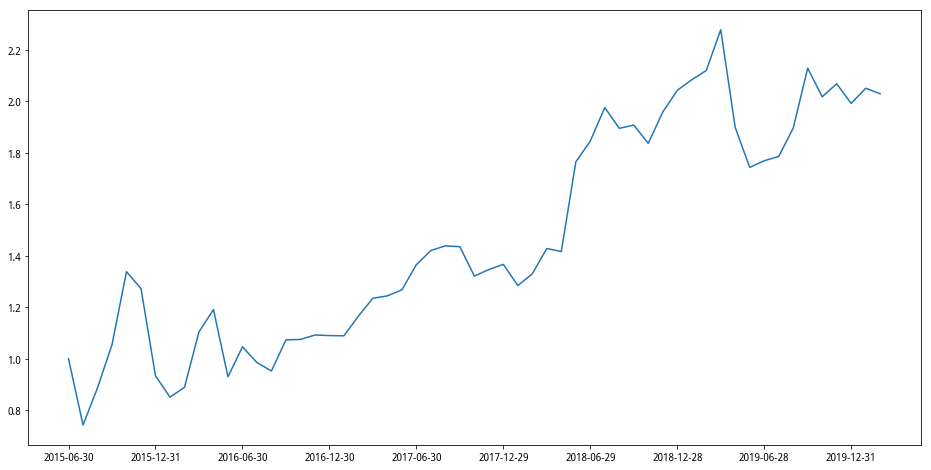

,zero,first,second,third,fourth,0-4
策略收益,0.20,-0.32,-0.38,-0.42,-0.72,1.03
策略年化收益,0.04,-0.08,-0.10,-0.11,-0.23,0.16
夏普比率,-0.01,-0.30,-0.32,-0.32,-0.60,0.34
最大回撤,0.18,0.69,0.70,0.70,0.83,0.36
年化波动率,0.19,0.40,0.43,0.47,0.46,0.36


In [609]:
stocks_js11=get_industry_stocks('801750')#计算机I
stocks_js11.remove('688555.XSHG')
all_prices_js11=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_js11=[1]
df_js11=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_js11['turnover_ratio']=pl_pro[months[j]].loc[stocks_js11,'turnover_ratio']
    df_js11['code']=pl_pro[months[j]].loc[stocks_js11,'code']
    df_js11['market_cap']=pl_pro[months[j]].loc[stocks_js11,'market_cap']
    df_js11.index=df_js11.code.values
    df_js11=df_js11[['turnover_ratio','market_cap']]
    df_js11=df_js11.sort_values('turnover_ratio').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_js11=get_price(stocks_js11,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_js11=get_price(stocks_js11,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_js11=list(vol0_js11[vol0_js11['volume']!=0].index)
    prices_js11=prices_js11.loc[vol0_js11,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_js11['ret']=prices_js11[months[j+1]]/prices_js11[months[j]]-1
    df_js11['ret_cap']=df_js11['ret']*df_js11['market_cap']
    five_df_js11=list(df_js11[int(len(df_js11)*i/5):int(len(df_js11)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_js11[i].append(all_prices_js11[i][-1]*(1+sum(five_df_js11[i]['ret_cap'])/sum(five_df_js11[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_js11[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_js11=list(all_prices_js11[0][i]/all_prices_js11[0][i-1]-all_prices_js11[4][i]/all_prices_js11[4][i-1] for i in range(1,len(all_prices_js11[0])))
price_delta_js11=[1]
for i in range(len(deltas_js11)):
    price_delta_js11.append(price_delta_js11[-1]*(1+deltas_js11[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_js11)
plt.xticks(xxx,xdate)
plt.show()

#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_js11=pd.DataFrame()
for i in range(0,5):
    df_allprices_js11[i]=all_prices_js11[i]
df_allprices_js11['0-4']=price_delta_js11

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_js11['date']=mmm
df_allprices_js11.set_index(df_allprices_js11['date'],inplace=True)
df_allprices_js11.drop(columns='date',axis=1,inplace=True)

df_allprices_js11.columns=['zero','first','second','third','fourth','0-4']
results_js11=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_js11.columns:
    results_js11[i] = get_risk_index(df_allprices_js11[i])
results_js11.round(decimals=2)

# 计算机I
pe_ratio

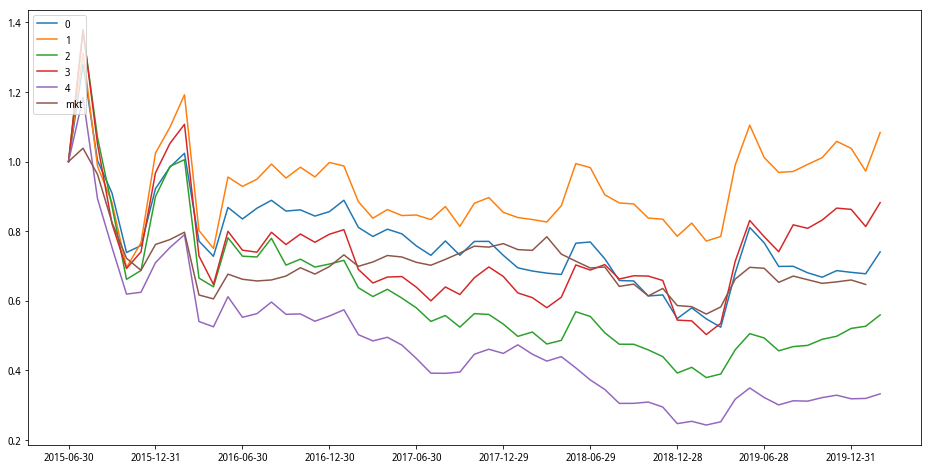

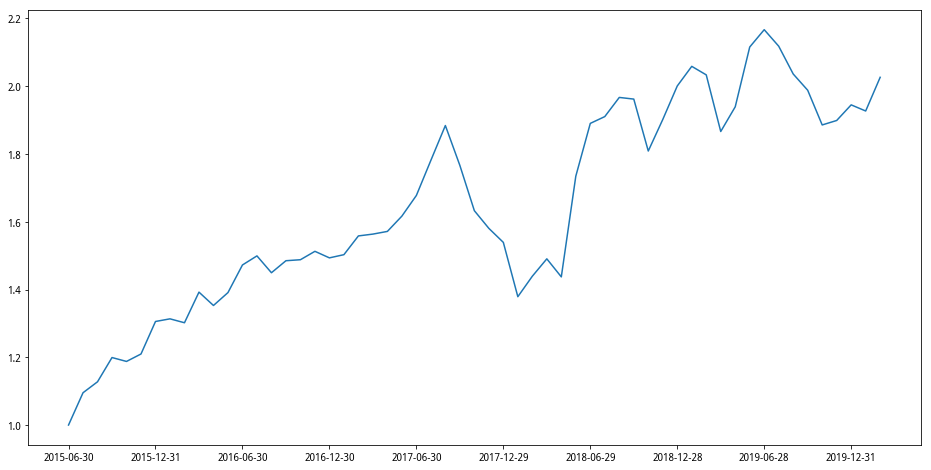

,zero,first,second,third,fourth,0-4
策略收益,-0.26,0.08,-0.44,-0.12,-0.67,1.03
策略年化收益,-0.06,0.02,-0.12,-0.03,-0.21,0.16
夏普比率,-0.29,-0.06,-0.39,-0.15,-0.73,0.67
最大回撤,0.59,0.47,0.72,0.64,0.80,0.27
年化波动率,0.35,0.40,0.40,0.44,0.34,0.18


In [610]:
stocks_js22=get_industry_stocks('801750')#计算机I
stocks_js22.remove('688555.XSHG')
all_prices_js22=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_js22=[1]
df_js22=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_js22['pe_ratio']=pl_pro[months[j]].loc[stocks_js22,'pe_ratio']
    df_js22['code']=pl_pro[months[j]].loc[stocks_js22,'code']
    df_js22['market_cap']=pl_pro[months[j]].loc[stocks_js22,'market_cap']
    df_js22.index=df_js22.code.values
    df_js22=df_js22[['pe_ratio','market_cap']]
    df_js22=df_js22.sort_values('pe_ratio').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_js22=get_price(stocks_js22,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_js22=get_price(stocks_js22,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_js22=list(vol0_js22[vol0_js22['volume']!=0].index)
    prices_js22=prices_js22.loc[vol0_js22,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_js22['ret']=prices_js22[months[j+1]]/prices_js22[months[j]]-1
    df_js22['ret_cap']=df_js22['ret']*df_js22['market_cap']
    five_df_js22=list(df_js22[int(len(df_js22)*i/5):int(len(df_js22)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_js22[i].append(all_prices_js22[i][-1]*(1+sum(five_df_js22[i]['ret_cap'])/sum(five_df_js22[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_js22[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_js22=list(all_prices_js22[0][i]/all_prices_js22[0][i-1]-all_prices_js22[4][i]/all_prices_js22[4][i-1] for i in range(1,len(all_prices_js22[0])))
price_delta_js22=[1]
for i in range(len(deltas_js22)):
    price_delta_js22.append(price_delta_js22[-1]*(1+deltas_js22[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_js22)
plt.xticks(xxx,xdate)
plt.show()

#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_js22=pd.DataFrame()
for i in range(0,5):
    df_allprices_js22[i]=all_prices_js22[i]
df_allprices_js22['0-4']=price_delta_js22

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_js22['date']=mmm
df_allprices_js22.set_index(df_allprices_js22['date'],inplace=True)
df_allprices_js22.drop(columns='date',axis=1,inplace=True)

df_allprices_js22.columns=['zero','first','second','third','fourth','0-4']
results_js22=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_js22.columns:
    results_js22[i] = get_risk_index(df_allprices_js22[i])
results_js22.round(decimals=2)

# 计算机I
总股本

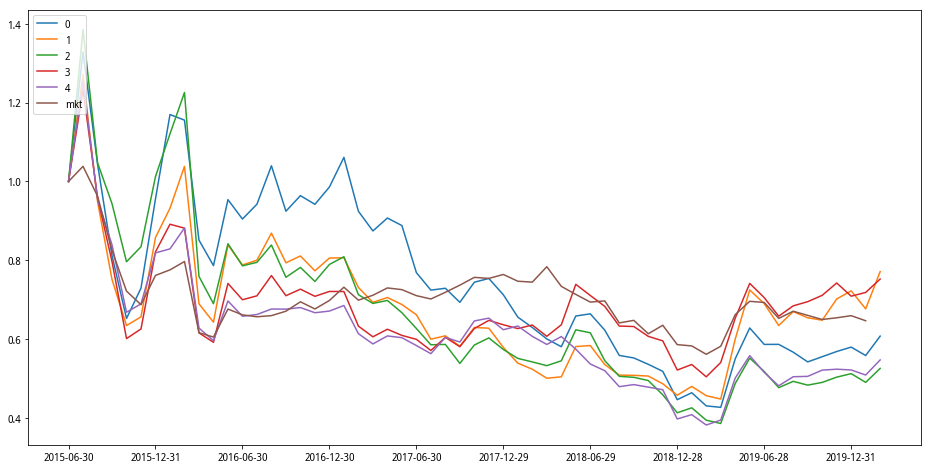

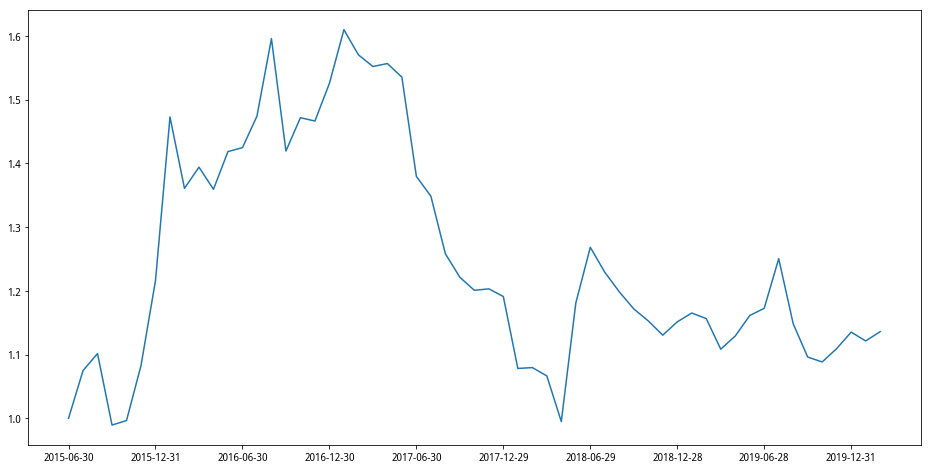

,zero,first,second,third,fourth,0-4
策略收益,-0.39,-0.23,-0.47,-0.25,-0.45,0.14
策略年化收益,-0.10,-0.05,-0.13,-0.06,-0.12,0.03
夏普比率,-0.34,-0.22,-0.42,-0.26,-0.48,-0.06
最大回撤,0.68,0.65,0.72,0.59,0.70,0.38
年化波动率,0.42,0.43,0.40,0.38,0.34,0.21


In [611]:
stocks_js33=get_industry_stocks('801750')#计算机I
stocks_js33.remove('688555.XSHG')
all_prices_js33=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_js33=[1]
df_js33=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_js33['capitalization']=pl_pro[months[j]].loc[stocks_js33,'capitalization']
    df_js33['code']=pl_pro[months[j]].loc[stocks_js33,'code']
    df_js33['market_cap']=pl_pro[months[j]].loc[stocks_js33,'market_cap']
    df_js33.index=df_js33.code.values
    df_js33=df_js33[['capitalization','market_cap']]
    df_js33=df_js33.sort_values('capitalization').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_js33=get_price(stocks_js33,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_js33=get_price(stocks_js33,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_js33=list(vol0_js33[vol0_js33['volume']!=0].index)
    prices_js33=prices_js33.loc[vol0_js33,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_js33['ret']=prices_js33[months[j+1]]/prices_js33[months[j]]-1
    df_js33['ret_cap']=df_js33['ret']*df_js33['market_cap']
    five_df_js33=list(df_js33[int(len(df_js33)*i/5):int(len(df_js33)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_js33[i].append(all_prices_js33[i][-1]*(1+sum(five_df_js33[i]['ret_cap'])/sum(five_df_js33[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_js33[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_js33=list(all_prices_js33[0][i]/all_prices_js33[0][i-1]-all_prices_js33[4][i]/all_prices_js33[4][i-1] for i in range(1,len(all_prices_js33[0])))
price_delta_js33=[1]
for i in range(len(deltas_js33)):
    price_delta_js33.append(price_delta_js33[-1]*(1+deltas_js33[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_js33)
plt.xticks(xxx,xdate)
plt.show()

#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_js33=pd.DataFrame()
for i in range(0,5):
    df_allprices_js33[i]=all_prices_js33[i]
df_allprices_js33['0-4']=price_delta_js33

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_js33['date']=mmm
df_allprices_js33.set_index(df_allprices_js33['date'],inplace=True)
df_allprices_js33.drop(columns='date',axis=1,inplace=True)

df_allprices_js33.columns=['zero','first','second','third','fourth','0-4']
results_js33=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_js33.columns:
    results_js33[i] = get_risk_index(df_allprices_js33[i])
results_js33.round(decimals=2)

# 银行I
turnover_ratio

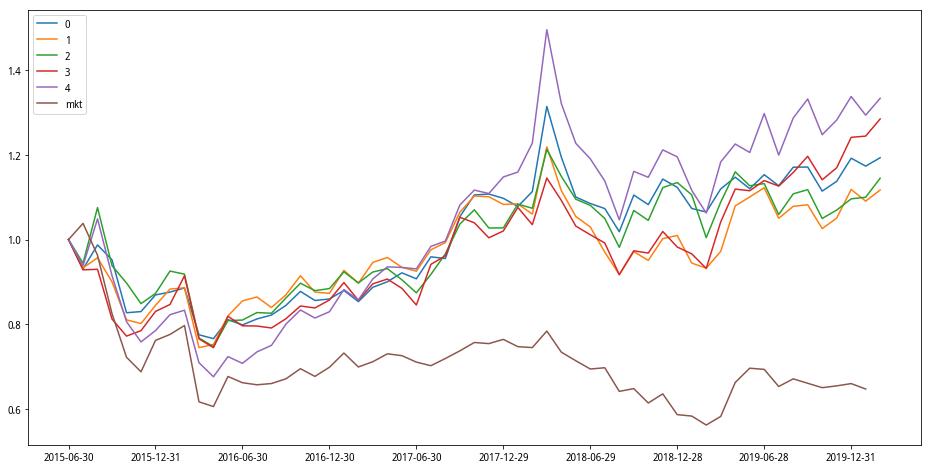

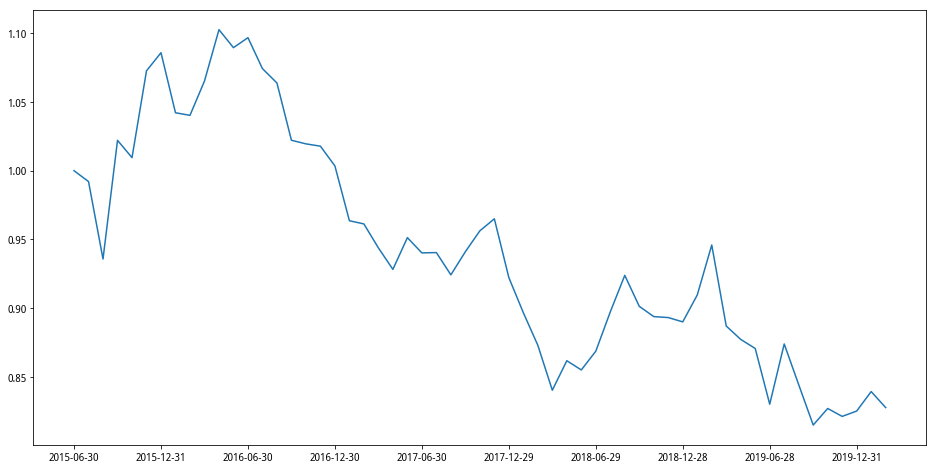

In [612]:
stocks_yh11=get_industry_stocks('801780')#银行
#stocks_yh11.remove('688555.XSHG')
all_prices_yh11=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_yh11=[1]
df_yh11=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_yh11['turnover_ratio']=pl_pro[months[j]].loc[stocks_yh11,'turnover_ratio']
    df_yh11['code']=pl_pro[months[j]].loc[stocks_yh11,'code']
    df_yh11['market_cap']=pl_pro[months[j]].loc[stocks_yh11,'market_cap']
    df_yh11.index=df_yh11.code.values
    df_yh11=df_yh11[['turnover_ratio','market_cap']]
    df_yh11=df_yh11.sort_values('turnover_ratio').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_yh11=get_price(stocks_yh11,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_yh11=get_price(stocks_yh11,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_yh11=list(vol0_yh11[vol0_yh11['volume']!=0].index)
    prices_yh11=prices_yh11.loc[vol0_yh11,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_yh11['ret']=prices_yh11[months[j+1]]/prices_yh11[months[j]]-1
    df_yh11['ret_cap']=df_yh11['ret']*df_yh11['market_cap']
    five_df_yh11=list(df_yh11[int(len(df_yh11)*i/5):int(len(df_yh11)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_yh11[i].append(all_prices_yh11[i][-1]*(1+sum(five_df_yh11[i]['ret_cap'])/sum(five_df_yh11[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_yh11[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_yh11=list(all_prices_yh11[0][i]/all_prices_yh11[0][i-1]-all_prices_yh11[4][i]/all_prices_yh11[4][i-1] for i in range(1,len(all_prices_yh11[0])))
price_delta_yh11=[1]
for i in range(len(deltas_yh11)):
    price_delta_yh11.append(price_delta_yh11[-1]*(1+deltas_yh11[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_yh11)
plt.xticks(xxx,xdate)
plt.show()

In [613]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_yh11=pd.DataFrame()
for i in range(0,5):
    df_allprices_yh11[i]=all_prices_yh11[i]
df_allprices_yh11['0-4']=price_delta_yh11

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_yh11['date']=mmm
df_allprices_yh11.set_index(df_allprices_yh11['date'],inplace=True)
df_allprices_yh11.drop(columns='date',axis=1,inplace=True)

df_allprices_yh11.columns=['zero','first','second','third','fourth','0-4']
results_yh11=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_yh11.columns:
    results_yh11[i] = get_risk_index(df_allprices_yh11[i])
results_yh11.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.19,0.12,0.15,0.29,0.33,-0.17
策略年化收益,0.04,0.02,0.03,0.05,0.06,-0.04
夏普比率,-0.01,-0.09,-0.06,0.07,0.10,-0.78
最大回撤,0.23,0.26,0.31,0.26,0.36,0.26
年化波动率,0.18,0.19,0.20,0.19,0.24,0.10


# 银行I，pe_ratio

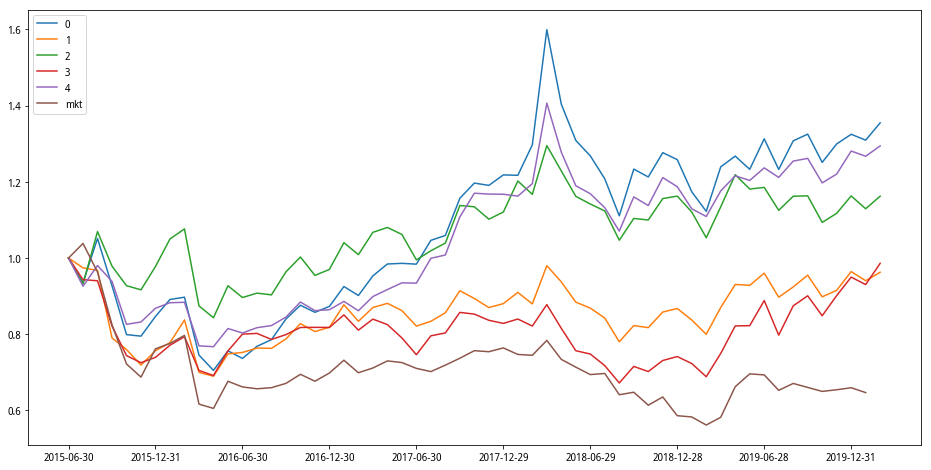

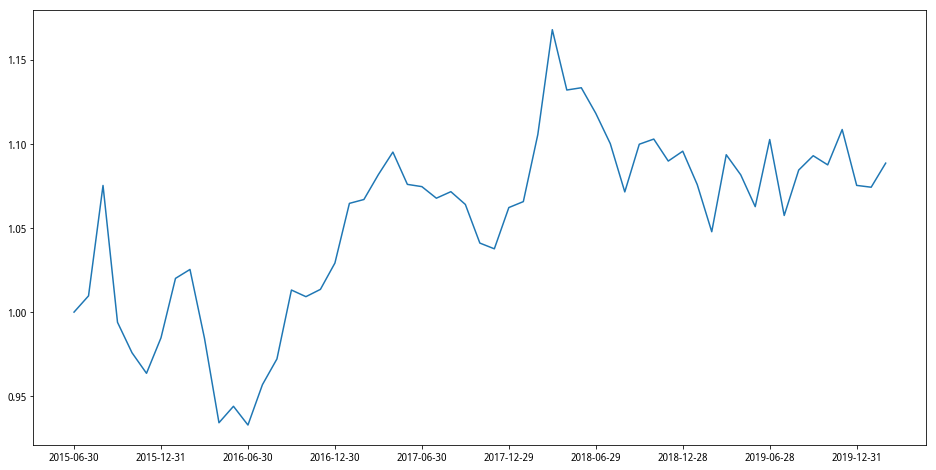

In [614]:
stocks_yh22=get_industry_stocks('801780')#银行
#stocks_yh22.remove('688555.XSHG')
all_prices_yh22=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_yh22=[1]
df_yh22=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_yh22['pe_ratio']=pl_pro[months[j]].loc[stocks_yh22,'pe_ratio']
    df_yh22['code']=pl_pro[months[j]].loc[stocks_yh22,'code']
    df_yh22['market_cap']=pl_pro[months[j]].loc[stocks_yh22,'market_cap']
    df_yh22.index=df_yh22.code.values
    df_yh22=df_yh22[['pe_ratio','market_cap']]
    df_yh22=df_yh22.sort_values('pe_ratio').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_yh22=get_price(stocks_yh22,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_yh22=get_price(stocks_yh22,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_yh22=list(vol0_yh22[vol0_yh22['volume']!=0].index)
    prices_yh22=prices_yh22.loc[vol0_yh22,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_yh22['ret']=prices_yh22[months[j+1]]/prices_yh22[months[j]]-1
    df_yh22['ret_cap']=df_yh22['ret']*df_yh22['market_cap']
    five_df_yh22=list(df_yh22[int(len(df_yh22)*i/5):int(len(df_yh22)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_yh22[i].append(all_prices_yh22[i][-1]*(1+sum(five_df_yh22[i]['ret_cap'])/sum(five_df_yh22[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_yh22[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_yh22=list(all_prices_yh22[0][i]/all_prices_yh22[0][i-1]-all_prices_yh22[4][i]/all_prices_yh22[4][i-1] for i in range(1,len(all_prices_yh22[0])))
price_delta_yh22=[1]
for i in range(len(deltas_yh22)):
    price_delta_yh22.append(price_delta_yh22[-1]*(1+deltas_yh22[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_yh22)
plt.xticks(xxx,xdate)
plt.show()

In [615]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_yh22=pd.DataFrame()
for i in range(0,5):
    df_allprices_yh22[i]=all_prices_yh22[i]
df_allprices_yh22['0-4']=price_delta_yh22

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_yh22['date']=mmm
df_allprices_yh22.set_index(df_allprices_yh22['date'],inplace=True)
df_allprices_yh22.drop(columns='date',axis=1,inplace=True)

df_allprices_yh22.columns=['zero','first','second','third','fourth','0-4']
results_yh22=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_yh22.columns:
    results_yh22[i] = get_risk_index(df_allprices_yh22[i])
results_yh22.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.35,-0.04,0.16,-0.01,0.29,0.09
策略年化收益,0.07,-0.01,0.03,-0.00,0.06,0.02
夏普比率,0.11,-0.25,-0.04,-0.23,0.09,-0.24
最大回撤,0.33,0.31,0.22,0.33,0.24,0.13
年化波动率,0.24,0.19,0.20,0.19,0.18,0.09


# 银行I
总股本

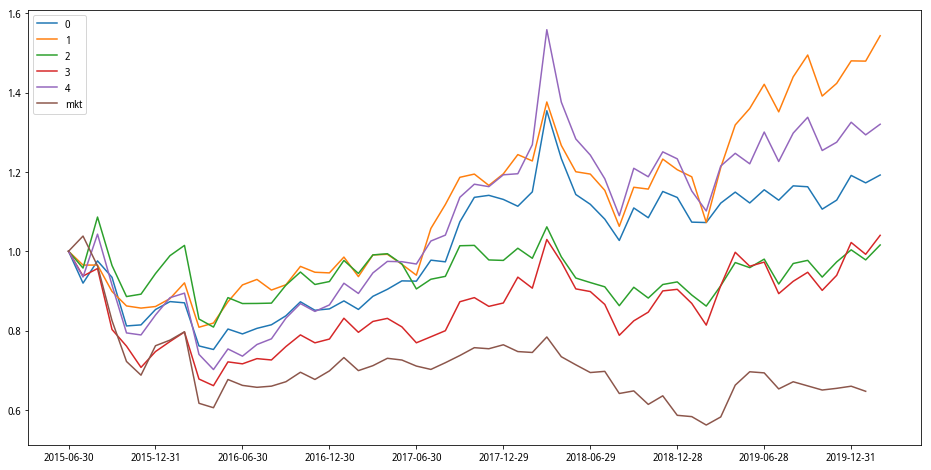

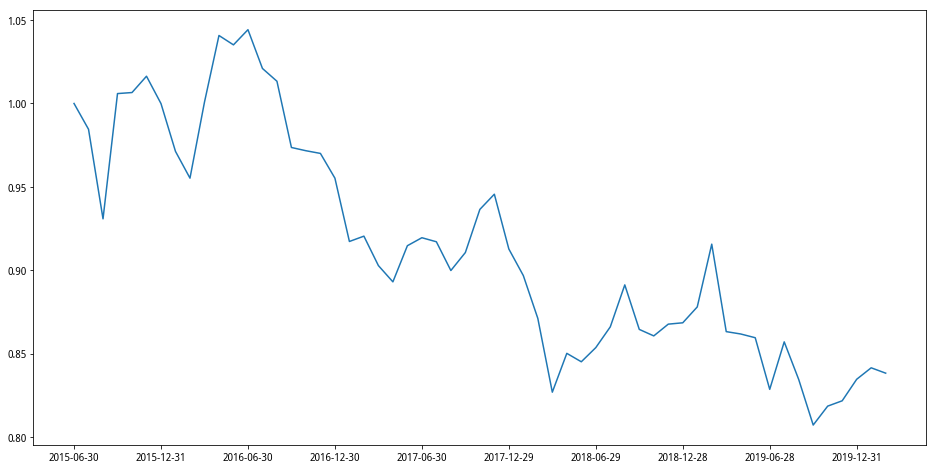

In [616]:
stocks_yh33=get_industry_stocks('801780')#银行
#stocks_yh33.remove('688555.XSHG')
all_prices_yh33=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_yh33=[1]
df_yh33=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_yh33['capitalization']=pl_pro[months[j]].loc[stocks_yh33,'capitalization']
    df_yh33['code']=pl_pro[months[j]].loc[stocks_yh33,'code']
    df_yh33['market_cap']=pl_pro[months[j]].loc[stocks_yh33,'market_cap']
    df_yh33.index=df_yh33.code.values
    df_yh33=df_yh33[['capitalization','market_cap']]
    df_yh33=df_yh33.sort_values('capitalization').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_yh33=get_price(stocks_yh33,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_yh33=get_price(stocks_yh33,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_yh33=list(vol0_yh33[vol0_yh33['volume']!=0].index)
    prices_yh33=prices_yh33.loc[vol0_yh33,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_yh33['ret']=prices_yh33[months[j+1]]/prices_yh33[months[j]]-1
    df_yh33['ret_cap']=df_yh33['ret']*df_yh33['market_cap']
    five_df_yh33=list(df_yh33[int(len(df_yh33)*i/5):int(len(df_yh33)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_yh33[i].append(all_prices_yh33[i][-1]*(1+sum(five_df_yh33[i]['ret_cap'])/sum(five_df_yh33[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_yh33[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_yh33=list(all_prices_yh33[0][i]/all_prices_yh33[0][i-1]-all_prices_yh33[4][i]/all_prices_yh33[4][i-1] for i in range(1,len(all_prices_yh33[0])))
price_delta_yh33=[1]
for i in range(len(deltas_yh33)):
    price_delta_yh33.append(price_delta_yh33[-1]*(1+deltas_yh33[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_yh33)
plt.xticks(xxx,xdate)
plt.show()

In [617]:
#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_yh33=pd.DataFrame()
for i in range(0,5):
    df_allprices_yh33[i]=all_prices_yh33[i]
df_allprices_yh33['0-4']=price_delta_yh33

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_yh33['date']=mmm
df_allprices_yh33.set_index(df_allprices_yh33['date'],inplace=True)
df_allprices_yh33.drop(columns='date',axis=1,inplace=True)

df_allprices_yh33.columns=['zero','first','second','third','fourth','0-4']
results_yh33=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_yh33.columns:
    results_yh33[i] = get_risk_index(df_allprices_yh33[i])
results_yh33.round(decimals=2)

,zero,first,second,third,fourth,0-4
策略收益,0.19,0.54,0.02,0.04,0.32,-0.16
策略年化收益,0.04,0.10,0.00,0.01,0.06,-0.04
夏普比率,-0.01,0.30,-0.20,-0.15,0.09,-0.84
最大回撤,0.25,0.23,0.26,0.34,0.33,0.23
年化波动率,0.18,0.19,0.19,0.21,0.24,0.09


# 国防军工I
turnover_ratio

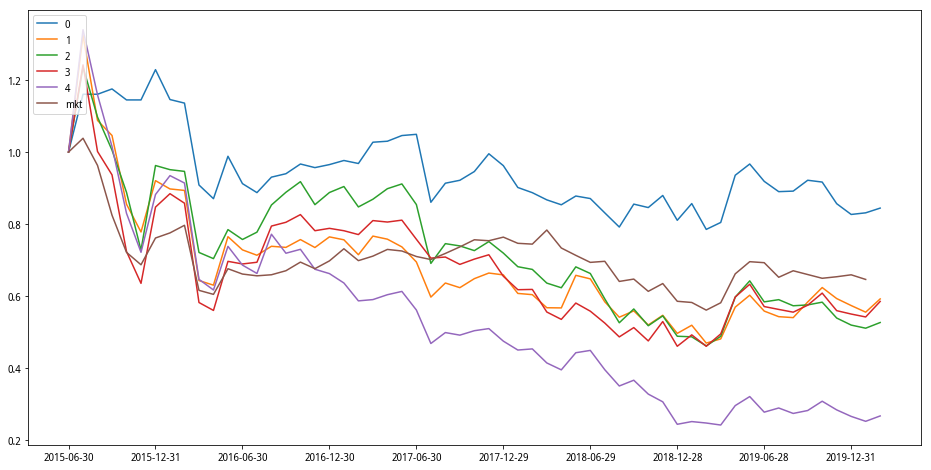

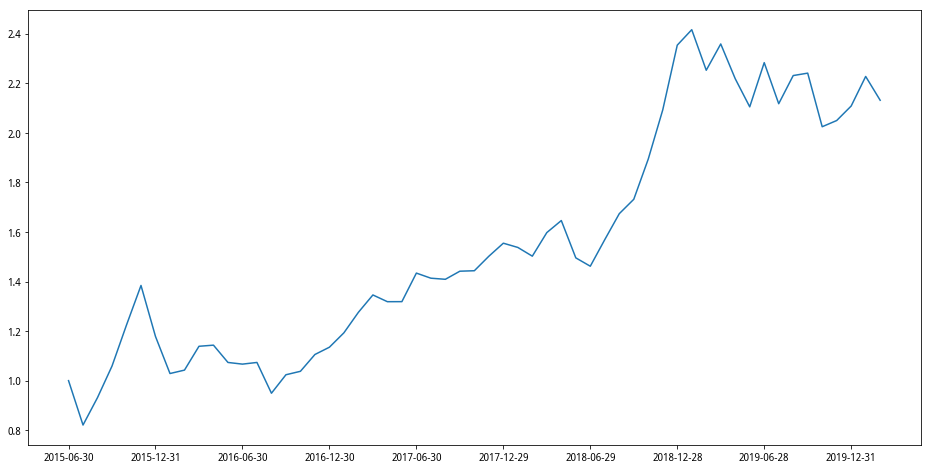

,zero,first,second,third,fourth,0-4
策略收益,-0.16,-0.41,-0.47,-0.41,-0.73,1.13
策略年化收益,-0.03,-0.10,-0.13,-0.11,-0.24,0.17
夏普比率,-0.34,-0.43,-0.50,-0.39,-0.74,0.52
最大回撤,0.36,0.64,0.63,0.63,0.82,0.31
年化波动率,0.22,0.34,0.33,0.38,0.38,0.26


In [618]:
stocks_gf11=get_industry_stocks('801740')#国防军工I
#stocks_gf11.remove('688555.XSHG')
all_prices_gf11=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_gf11=[1]
df_gf11=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_gf11['turnover_ratio']=pl_pro[months[j]].loc[stocks_gf11,'turnover_ratio']
    df_gf11['code']=pl_pro[months[j]].loc[stocks_gf11,'code']
    df_gf11['market_cap']=pl_pro[months[j]].loc[stocks_gf11,'market_cap']
    df_gf11.index=df_gf11.code.values
    df_gf11=df_gf11[['turnover_ratio','market_cap']]
    df_gf11=df_gf11.sort_values('turnover_ratio').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_gf11=get_price(stocks_gf11,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_gf11=get_price(stocks_gf11,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_gf11=list(vol0_gf11[vol0_gf11['volume']!=0].index)
    prices_gf11=prices_gf11.loc[vol0_gf11,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_gf11['ret']=prices_gf11[months[j+1]]/prices_gf11[months[j]]-1
    df_gf11['ret_cap']=df_gf11['ret']*df_gf11['market_cap']
    five_df_gf11=list(df_gf11[int(len(df_gf11)*i/5):int(len(df_gf11)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_gf11[i].append(all_prices_gf11[i][-1]*(1+sum(five_df_gf11[i]['ret_cap'])/sum(five_df_gf11[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_gf11[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_gf11=list(all_prices_gf11[0][i]/all_prices_gf11[0][i-1]-all_prices_gf11[4][i]/all_prices_gf11[4][i-1] for i in range(1,len(all_prices_gf11[0])))
price_delta_gf11=[1]
for i in range(len(deltas_gf11)):
    price_delta_gf11.append(price_delta_gf11[-1]*(1+deltas_gf11[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_gf11)
plt.xticks(xxx,xdate)
plt.show()

#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_gf11=pd.DataFrame()
for i in range(0,5):
    df_allprices_gf11[i]=all_prices_gf11[i]
df_allprices_gf11['0-4']=price_delta_gf11

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_gf11['date']=mmm
df_allprices_gf11.set_index(df_allprices_gf11['date'],inplace=True)
df_allprices_gf11.drop(columns='date',axis=1,inplace=True)

df_allprices_gf11.columns=['zero','first','second','third','fourth','0-4']
results_gf11=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_gf11.columns:
    results_gf11[i] = get_risk_index(df_allprices_gf11[i])
results_gf11.round(decimals=2)

# 国防军工I
pe_ratio

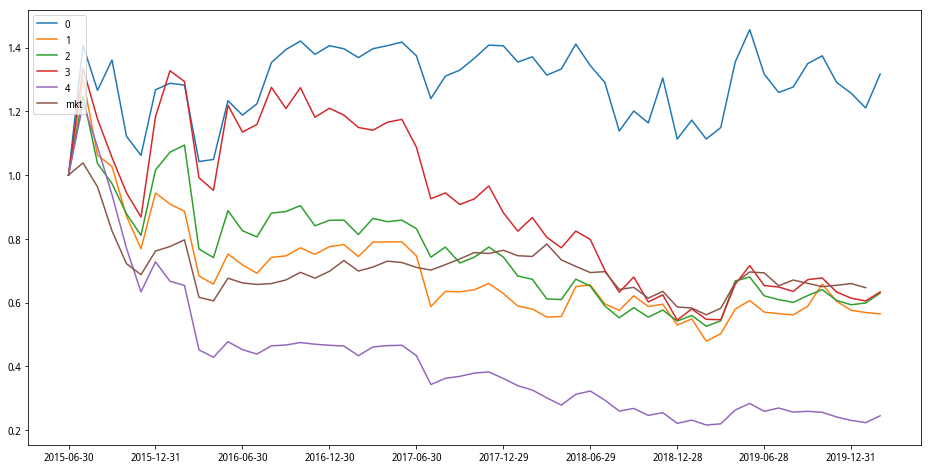

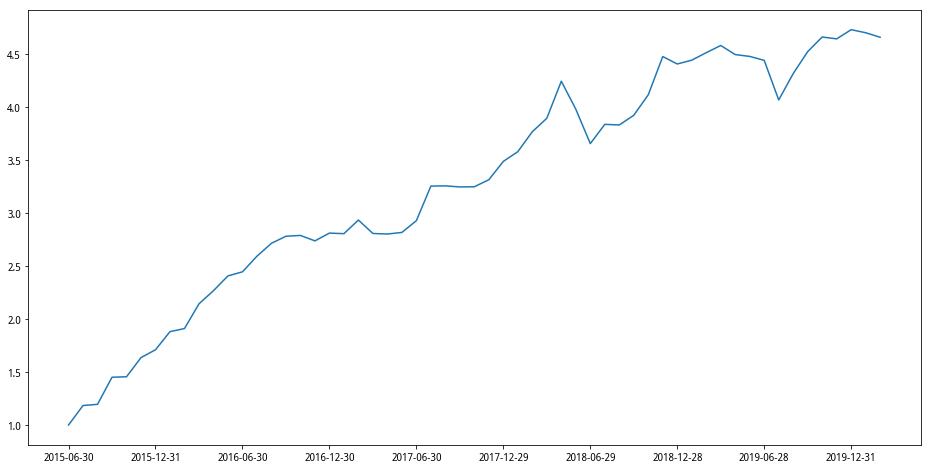

,zero,first,second,third,fourth,0-4
策略收益,0.32,-0.44,-0.37,-0.37,-0.76,3.66
策略年化收益,0.06,-0.11,-0.09,-0.09,-0.26,0.38
夏普比率,0.06,-0.47,-0.41,-0.35,-0.91,1.83
最大回撤,0.26,0.63,0.58,0.59,0.82,0.14
年化波动率,0.33,0.33,0.32,0.38,0.33,0.19


In [619]:
stocks_gf22=get_industry_stocks('801740')#国防军工I
#stocks_gf22.remove('688555.XSHG')
all_prices_gf22=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_gf22=[1]
df_gf22=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_gf22['pe_ratio']=pl_pro[months[j]].loc[stocks_gf22,'pe_ratio']
    df_gf22['code']=pl_pro[months[j]].loc[stocks_gf22,'code']
    df_gf22['market_cap']=pl_pro[months[j]].loc[stocks_gf22,'market_cap']
    df_gf22.index=df_gf22.code.values
    df_gf22=df_gf22[['pe_ratio','market_cap']]
    df_gf22=df_gf22.sort_values('pe_ratio').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_gf22=get_price(stocks_gf22,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_gf22=get_price(stocks_gf22,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_gf22=list(vol0_gf22[vol0_gf22['volume']!=0].index)
    prices_gf22=prices_gf22.loc[vol0_gf22,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_gf22['ret']=prices_gf22[months[j+1]]/prices_gf22[months[j]]-1
    df_gf22['ret_cap']=df_gf22['ret']*df_gf22['market_cap']
    five_df_gf22=list(df_gf22[int(len(df_gf22)*i/5):int(len(df_gf22)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_gf22[i].append(all_prices_gf22[i][-1]*(1+sum(five_df_gf22[i]['ret_cap'])/sum(five_df_gf22[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_gf22[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_gf22=list(all_prices_gf22[0][i]/all_prices_gf22[0][i-1]-all_prices_gf22[4][i]/all_prices_gf22[4][i-1] for i in range(1,len(all_prices_gf22[0])))
price_delta_gf22=[1]
for i in range(len(deltas_gf22)):
    price_delta_gf22.append(price_delta_gf22[-1]*(1+deltas_gf22[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_gf22)
plt.xticks(xxx,xdate)
plt.show()

#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_gf22=pd.DataFrame()
for i in range(0,5):
    df_allprices_gf22[i]=all_prices_gf22[i]
df_allprices_gf22['0-4']=price_delta_gf22

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_gf22['date']=mmm
df_allprices_gf22.set_index(df_allprices_gf22['date'],inplace=True)
df_allprices_gf22.drop(columns='date',axis=1,inplace=True)

df_allprices_gf22.columns=['zero','first','second','third','fourth','0-4']
results_gf22=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_gf22.columns:
    results_gf22[i] = get_risk_index(df_allprices_gf22[i])
results_gf22.round(decimals=2)

# 国防军工I
总股本

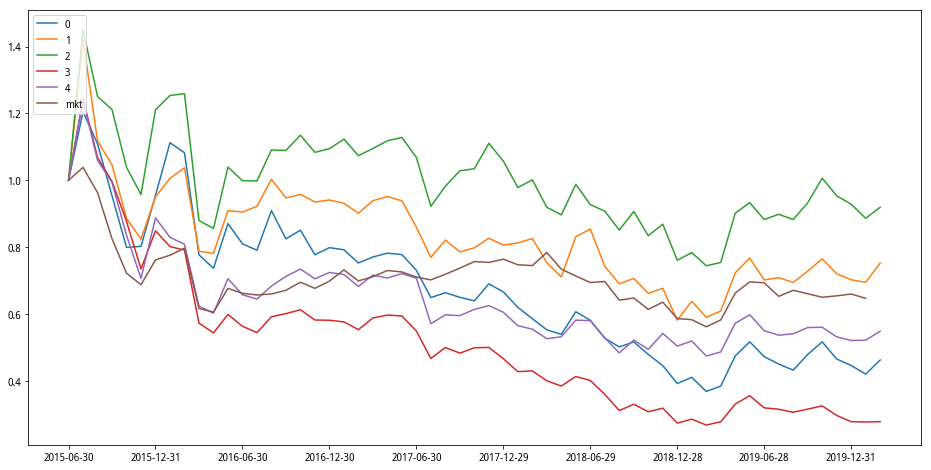

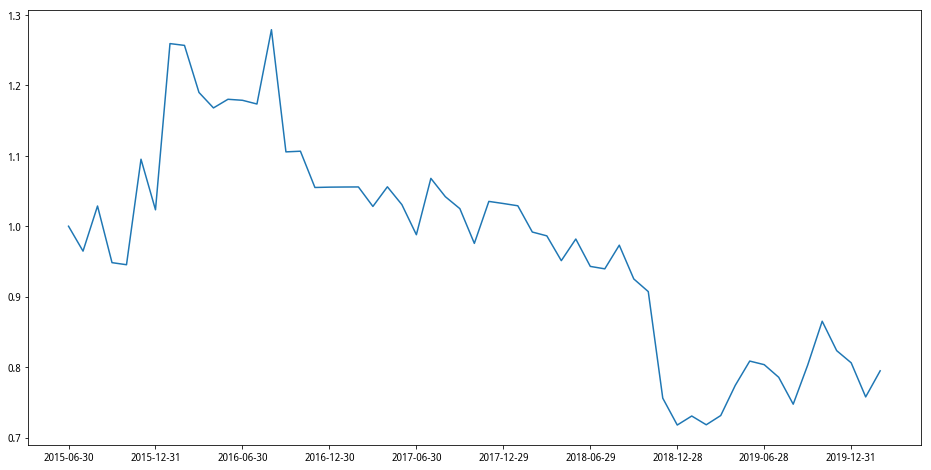

,zero,first,second,third,fourth,0-4
策略收益,-0.54,-0.25,-0.08,-0.72,-0.45,-0.21
策略年化收益,-0.15,-0.06,-0.02,-0.24,-0.12,-0.05
夏普比率,-0.56,-0.28,-0.16,-0.90,-0.51,-0.41
最大回撤,0.69,0.59,0.49,0.78,0.62,0.44
年化波动率,0.34,0.35,0.37,0.31,0.32,0.22


In [620]:
stocks_gf33=get_industry_stocks('801740')#国防军工I
#stocks_gf33.remove('688555.XSHG')
all_prices_gf33=[[1],[1],[1],[1],[1]]
mkt_price=[]
delta_gf33=[1]
df_gf33=pd.DataFrame()
for j in range(3,len(months)-1): 
    df_gf33['capitalization']=pl_pro[months[j]].loc[stocks_gf33,'capitalization']
    df_gf33['code']=pl_pro[months[j]].loc[stocks_gf33,'code']
    df_gf33['market_cap']=pl_pro[months[j]].loc[stocks_gf33,'market_cap']
    df_gf33.index=df_gf33.code.values
    df_gf33=df_gf33[['capitalization','market_cap']]
    df_gf33=df_gf33.sort_values('capitalization').dropna()
    #得到股票价格两个间隔月底的价格及市场两个间隔月底的价格，用于计算月度回报率，建议大家自己逐行运行理解
    prices_gf33=get_price(stocks_gf33,start_date=months[j-3],end_date=months[j+1],fields='close').iloc[0,:,:].T.dropna().loc[:,months[j]:months[j+1]].iloc[:,[0,-1]]
    mkt_price.append(get_price('000001.XSHG',start_date=months[j],end_date=months[j],fields='close')['close'][0])
    #滚动去除停牌及上市不足三个月的股票，每个月份除去在当月上市不足三个月的股票
    vol0_gf33=get_price(stocks_gf33,start_date=months[j],end_date=months[j],fields='volume').iloc[:,0,:].dropna()
    vol0_gf33=list(vol0_gf33[vol0_gf33['volume']!=0].index)
    prices_gf33=prices_gf33.loc[vol0_gf33,:].dropna()
    #计算各股票每月收益率并得到各组股票代码
    df_gf33['ret']=prices_gf33[months[j+1]]/prices_gf33[months[j]]-1
    df_gf33['ret_cap']=df_gf33['ret']*df_gf33['market_cap']
    five_df_gf33=list(df_gf33[int(len(df_gf33)*i/5):int(len(df_gf33)*(i+1)/5)] for i in range(5))#按照因子大小排序分为五个部分
    #按市值加权，计算各组合每月收益率
    for i in range(5):
        all_prices_gf33[i].append(all_prices_gf33[i][-1]*(1+sum(five_df_gf33[i]['ret_cap'])/sum(five_df_gf33[i]['market_cap'])))

#投资组合分组收益的净值图        
mkt_price=list(map(lambda x:x/mkt_price[0],mkt_price))
plt.figure(figsize=(16,8))

xdate=[]
for i in range(1,11):
    xdate.append(months[i*6-1])
xxx=range(0,len(months),6)

for i in range(5):
    plt.plot(all_prices_gf33[i],label=i)
plt.plot(mkt_price,label='mkt')
plt.legend(loc=2)
plt.xticks(xxx,xdate)
plt.show()

#计算0-4组合的收益率并画图
deltas_gf33=list(all_prices_gf33[0][i]/all_prices_gf33[0][i-1]-all_prices_gf33[4][i]/all_prices_gf33[4][i-1] for i in range(1,len(all_prices_gf33[0])))
price_delta_gf33=[1]
for i in range(len(deltas_gf33)):
    price_delta_gf33.append(price_delta_gf33[-1]*(1+deltas_gf33[i]))
plt.figure(figsize=(16,8))
plt.plot(price_delta_gf33)
plt.xticks(xxx,xdate)
plt.show()

#计算excess returns, annualized returns, annualized volatility, the Sharpe ratios, and maximum drawdowns
df_allprices_gf33=pd.DataFrame()
for i in range(0,5):
    df_allprices_gf33[i]=all_prices_gf33[i]
df_allprices_gf33['0-4']=price_delta_gf33

#计算风险指标函数
def get_risk_index(pct_se):
    return_se = pct_se-1
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(12/len(return_se))-1)
    vol = (pct_se.shift(-1)/pct_se).std()*np.sqrt(12)
    sharpe = (total_an_returns-0.04)/(np.std(pct_se.shift(-1)/pct_se)*12**0.5)
    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    return total_returns,total_an_returns,sharpe,max_drawdown,vol

mmm=months.copy()
for i in range(0,3):
    mmm.remove(mmm[i])
df_allprices_gf33['date']=mmm
df_allprices_gf33.set_index(df_allprices_gf33['date'],inplace=True)
df_allprices_gf33.drop(columns='date',axis=1,inplace=True)

df_allprices_gf33.columns=['zero','first','second','third','fourth','0-4']
results_gf33=pd.DataFrame(index = ['策略收益','策略年化收益','夏普比率','最大回撤','年化波动率'])
for i in df_allprices_gf33.columns:
    results_gf33[i] = get_risk_index(df_allprices_gf33[i])
results_gf33.round(decimals=2)